In [2]:
# %pip install python-dotenv
# %pip install seaborn
# %pip install snowflake-snowpark-python

In [1]:
import pandas as pd
import numpy as np
import os
import json
import sys

from dotenv import load_dotenv

# Snowflake imports for Snowpark 
import snowflake.connector as sf
import snowflake.snowpark.types as T
from snowflake.snowpark import Session

In [2]:
load_dotenv()

# Connect to Snowflake
USER = os.getenv("SNOWFLAKE_USER")
PASSWORD = os.getenv("SNOWFLAKE_PASSWORD")
ACCOUNT = os.getenv("SNOWFLAKE_ACCOUNT")
WAREHOUSE = os.getenv("SNOWFLAKE_WAREHOUSE")
DATABASE = os.getenv("SNOWFLAKE_DATABASE")
SCHEMA = os.getenv("SNOWFLAKE_SCHEMA")
ROLE = os.getenv("SNOWFLAKE_ROLE")

connection_parameters = {
    "account": ACCOUNT,
    "user": USER,
    "password": PASSWORD,
    "role": ROLE,
    "warehouse": WAREHOUSE,
    "database": DATABASE,
    "schema": SCHEMA,
}

# create Snowpark session
session = Session.builder.configs(connection_parameters).create()

c:\Users\panha.vuthy\AppData\Local\Programs\Python\Python311\Lib\site-packages\snowflake\connector\config_manager.py:351: UserWarning: Bad owner or permissions on C:\Users\panha.vuthy\AppData\Local\snowflake\config.toml
  warn(f"Bad owner or permissions on {str(filep)}{chmod_message}")


# Demand forecasting with ```ARIMA``` model

**Data Collection**

In [3]:
# query and filling data with 0 is done in Snowflake
def get_data(product_sku, customer_segment):
    data = session.sql(f"""
    WITH sales_data AS (
    SELECT 
        FACT_ORDER_LINE_ITEM_BASE.ORDER_DATE AS "DATE",
        LU_CUS_RFM_SEGMENT.RFM_SEGMENT_CODE AS "CUSTOMER_SEGMENT",
        SUM(FACT_ORDER_LINE_ITEM_BASE.ORDERED_QUANTITY) AS "UNITS_SOLD"
    FROM 
        FACT_ORDER_LINE_ITEM_BASE
    LEFT JOIN 
        LU_PRD_PRODUCT
    ON 
        FACT_ORDER_LINE_ITEM_BASE.PRODUCT_CODE = LU_PRD_PRODUCT.PRODUCT_CODE
    LEFT JOIN 
        LU_PRD_PRODUCT_SKU
    ON 
        LU_PRD_PRODUCT_SKU.PRODUCT_SKU = LU_PRD_PRODUCT.PRODUCT_SKU
    LEFT JOIN 
        LU_CUS_CUSTOMER 
    ON 
        FACT_ORDER_LINE_ITEM_BASE.CUSTOMER_CODE = LU_CUS_CUSTOMER.CUSTOMER_CODE
    LEFT JOIN 
        LU_CUS_RFM_SEGMENT
    ON 
        LU_CUS_RFM_SEGMENT.RFM_SEGMENT_CODE = LU_CUS_CUSTOMER.RFM_SEGMENT_CODE
    WHERE 
        LU_PRD_PRODUCT_SKU.PRODUCT_SKU IN ('{product_sku}')
        AND LU_CUS_RFM_SEGMENT.RFM_SEGMENT_CODE = {customer_segment}
    GROUP BY 
        FACT_ORDER_LINE_ITEM_BASE.ORDER_DATE, LU_CUS_RFM_SEGMENT.RFM_SEGMENT_CODE
),

date_range AS (
    SELECT 
        MIN(FACT_ORDER_LINE_ITEM_BASE.ORDER_DATE) AS MIN_DATE,
        MAX(FACT_ORDER_LINE_ITEM_BASE.ORDER_DATE) AS MAX_DATE
    FROM 
        FACT_ORDER_LINE_ITEM_BASE
    LEFT JOIN 
        LU_PRD_PRODUCT
    ON 
        FACT_ORDER_LINE_ITEM_BASE.PRODUCT_CODE = LU_PRD_PRODUCT.PRODUCT_CODE
    LEFT JOIN
        LU_PRD_PRODUCT_SKU
    ON 
        LU_PRD_PRODUCT.PRODUCT_SKU = LU_PRD_PRODUCT_SKU.PRODUCT_SKU
    WHERE 
        LU_PRD_PRODUCT_SKU.PRODUCT_SKU IN ('{product_sku}')
)

SELECT 
    LU_CAL_DATE.DATE AS "DATE",
    COALESCE(sales_data.CUSTOMER_SEGMENT, {customer_segment}) AS "CUSTOMER_SEGMENT",
    COALESCE(sales_data.UNITS_SOLD, 0) AS "UNITS_SOLD"
FROM 
    LU_CAL_DATE
LEFT JOIN 
    sales_data
ON 
    LU_CAL_DATE.DATE = sales_data.DATE
JOIN 
    date_range
ON 
    LU_CAL_DATE.DATE BETWEEN date_range.MIN_DATE AND date_range.MAX_DATE
WHERE 
    YEAR(LU_CAL_DATE.DATE) BETWEEN 2021 AND 2023
ORDER BY 
    LU_CAL_DATE.DATE ASC;
    """).collect()
    return data

In [4]:
product_sku = 'B33_S3'
# each number represents a customer segment code
customer_segement = [1, 2, 3, 4, 5, 6, 7, 8, 9]

In [5]:
data_collection = {}
for segment in customer_segement:
    data = pd.DataFrame(get_data(product_sku, segment))
    data_collection[segment] = data
# data_frame = pd.DataFrame(data_collection)

## Data Exploratory

**Demand Trend for each Customer Segment**

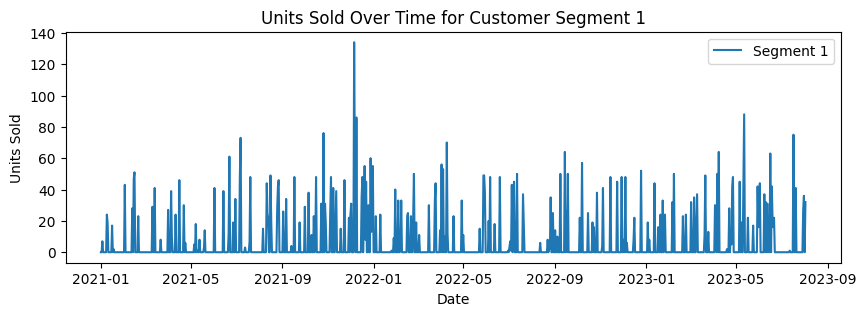

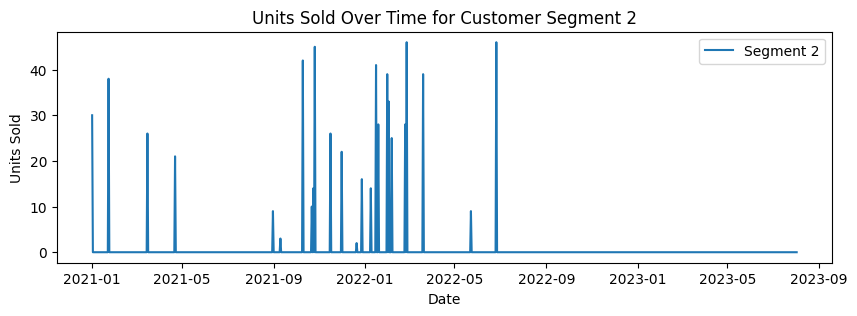

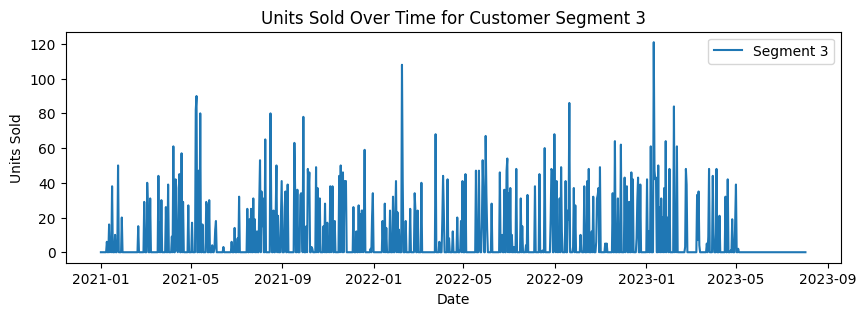

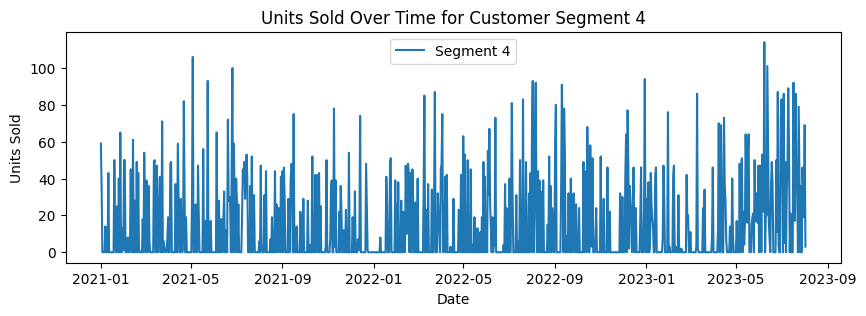

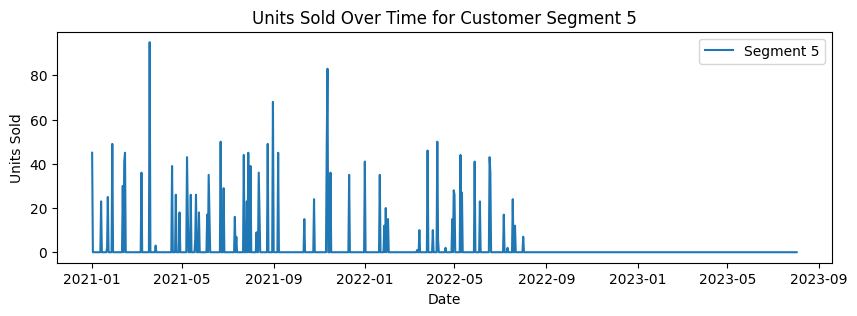

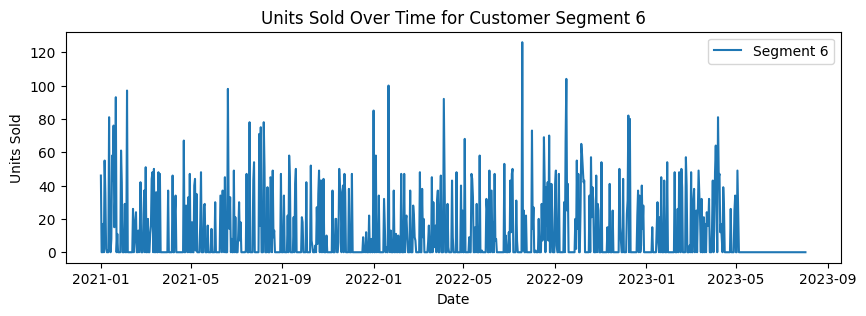

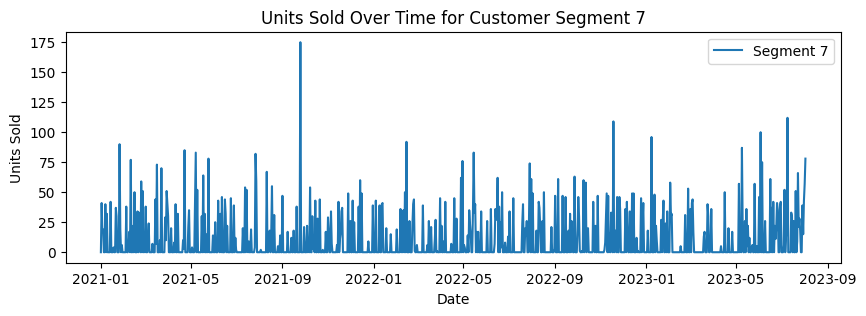

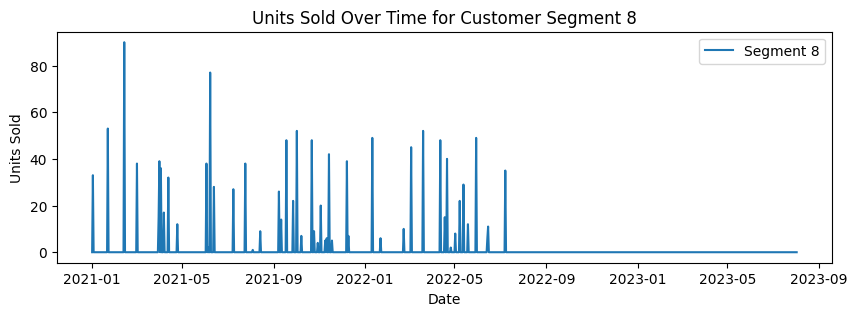

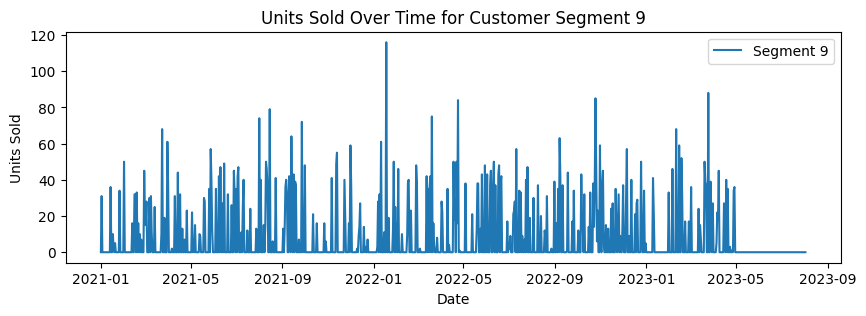

In [6]:
# Plot the time series data for each customer segment
from matplotlib import pyplot as plt

for segment, data in data_collection.items():
    plt.figure(figsize=(10, 3))
    plt.plot(data['DATE'], data['UNITS_SOLD'], label=f'Segment {segment}')
    
    # Add title and labels
    plt.title(f'Units Sold Over Time for Customer Segment {segment}')
    plt.xlabel('Date')
    plt.ylabel('Units Sold')
    plt.legend()
    
    # Show the plot
    plt.show()

**Statistical Testing**

In [7]:
from statsmodels.tsa.stattools import adfuller

stationarity_results = {}

for segment, data in data_collection.items():
    if data['UNITS_SOLD'].nunique() == 1:
        # Skip this segment as UNIT_SOLD is constant
        continue
    result = adfuller(data['UNITS_SOLD'])
    stationarity_results[segment] = {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Stationary': result[1] <= 0.05
    }
    # Unit Solds is all Zero, continue to next segment
    if result[1] > 0.05:
        continue

stationarity_results

{1: {'ADF Statistic': -29.039289314779506, 'p-value': 0.0, 'Stationary': True},
 2: {'ADF Statistic': -3.712001191119913,
  'p-value': 0.00394747867673462,
  'Stationary': True},
 3: {'ADF Statistic': -10.29357559181344,
  'p-value': 3.518326800363882e-18,
  'Stationary': True},
 4: {'ADF Statistic': -8.284971389747179,
  'p-value': 4.4157994047390513e-13,
  'Stationary': True},
 5: {'ADF Statistic': -28.51925367673372, 'p-value': 0.0, 'Stationary': True},
 6: {'ADF Statistic': -28.497467137190522, 'p-value': 0.0, 'Stationary': True},
 7: {'ADF Statistic': -18.01868328344336,
  'p-value': 2.6997267699134645e-30,
  'Stationary': True},
 8: {'ADF Statistic': -12.679107740434644,
  'p-value': 1.1977370199938867e-23,
  'Stationary': True},
 9: {'ADF Statistic': -13.344998411675519,
  'p-value': 5.818555826418687e-25,
  'Stationary': True}}

**Outlier Treatment**

In [8]:
from scipy import stats
import pandas as pd

# Function to detect and treat outliers
def treat_outliers(data):
    # Ensure that UNITS_SOLD is numeric (converting all types to float)
    data['UNITS_SOLD'] = pd.to_numeric(data['UNITS_SOLD'], errors='coerce')
    
    # Calculate z-scores
    z_scores = np.abs(stats.zscore(data['UNITS_SOLD']))
    
    # Find outliers where the z-score is greater than 3
    outliers = np.where(z_scores > 3)[0]
    
    # Replace outliers with the mean value of UNITS_SOLD
    mean_value = data['UNITS_SOLD'].mean()
    data.loc[outliers, 'UNITS_SOLD'] = mean_value
    
    return data

# Apply the function to each segment's data
for segment in data_collection:
    data_collection[segment] = treat_outliers(data_collection[segment])


In [9]:
data_collection[1]

,DATE,CUSTOMER_SEGMENT,UNITS_SOLD
0,2021-01-01,1,0.0
1,2021-01-02,1,0.0
2,2021-01-03,1,7.0
3,2021-01-04,1,0.0
4,2021-01-05,1,0.0
...,...,...,...
939,2023-07-29,1,0.0
940,2023-07-30,1,27.0
941,2023-07-31,1,36.0
942,2023-08-01,1,0.0


**Store Cleaned Data for Demand forcasting to ```FACT_DEMAND_FORECASTING_CLEANED``` table**

In [ ]:
# Combine all elements of data_collection into a single DataFrame
combined_data = pd.concat(data_collection.values(), ignore_index=True)
# Display the combined DataFrame
combined_data['PRODUCT_SKU'] = product_sku
combined_data

,DATE,CUSTOMER_SEGMENT,UNITS_SOLD,PRODUCT_SKU
0,2021-01-01,1,0.0,B33_S3
1,2021-01-02,1,0.0,B33_S3
2,2021-01-03,1,7.0,B33_S3
3,2021-01-04,1,0.0,B33_S3
4,2021-01-05,1,0.0,B33_S3
...,...,...,...,...
8491,2023-07-29,9,0.0,B33_S3
8492,2023-07-30,9,0.0,B33_S3
8493,2023-07-31,9,0.0,B33_S3
8494,2023-08-01,9,0.0,B33_S3


In [11]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8496 entries, 0 to 8495
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DATE              8496 non-null   object 
 1   CUSTOMER_SEGMENT  8496 non-null   int64  
 2   UNITS_SOLD        8496 non-null   float64
 3   PRODUCT_SKU       8496 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 265.6+ KB


In [12]:
# change units sold to integer
combined_data['UNITS_SOLD'] = combined_data['UNITS_SOLD'].astype(int)

In [13]:
# Function to create the table if it doesn't exist
def create_table_demand_forcast_cleaned_if_not_exists(table_name):
    create_table_query = f"""
    CREATE TABLE IF NOT EXISTS {table_name} (
        DATE DATE,
        CUSTOMER_SEGMENT INT,
        UNITS_SOLD INT,
        PRODUCT_SKU STRING
    );
    """
    session.sql(create_table_query).collect()  # Execute the query

In [14]:
# Function to insert the pandas dataframe into Snowflake table using Snowpark
def insert_pandas_dataframe_to_snowflake(session, pandas_df, table_name, schema):
    # Convert pandas DataFrame to Snowpark DataFrame
    snowpark_df = session.create_dataframe(pandas_df, schema=schema)
    product_sku = pandas_df['PRODUCT_SKU'][0]
    # Write the Snowpark DataFrame into Snowflake table
    session.sql(f"DELETE FROM {table_name} WHERE PRODUCT_SKU = '{product_sku}'").collect()
    snowpark_df.write.mode("append").save_as_table(f"{table_name}")
    return snowpark_df

In [15]:
from snowflake.snowpark.types import StructType, StructField, IntegerType, FloatType, StringType, DateType

training_table = "FACT_DEMAND_FORECASTING_CLEANED"
# schema structure for pandas DataFrame convert to Snowpark DataFrame
schema = StructType([
        StructField("DATE", DateType()),
        StructField("CUSTOMER_SEMENT", IntegerType()),
        StructField("UNITS_SOLD", IntegerType()),
        StructField("PRODUCT_SKU", StringType())
    ])

create_table_demand_forcast_cleaned_if_not_exists(training_table)
snowpark_df = insert_pandas_dataframe_to_snowflake(session, combined_data, training_table, schema)
# Convert pandas DataFrame to Snowpark DataFrame

In [16]:
snowpark_df.show()

------------------------------------------------------------------
|"DATE"      |"CUSTOMER_SEGMENT"  |"UNITS_SOLD"  |"PRODUCT_SKU"  |
------------------------------------------------------------------
|2021-01-01  |1                   |0             |B33_S3         |
|2021-01-02  |1                   |0             |B33_S3         |
|2021-01-03  |1                   |7             |B33_S3         |
|2021-01-04  |1                   |0             |B33_S3         |
|2021-01-05  |1                   |0             |B33_S3         |
|2021-01-06  |1                   |0             |B33_S3         |
|2021-01-07  |1                   |0             |B33_S3         |
|2021-01-08  |1                   |0             |B33_S3         |
|2021-01-09  |1                   |24            |B33_S3         |
|2021-01-10  |1                   |19            |B33_S3         |
------------------------------------------------------------------



**Model Training using ```ARIMA``` Model**

In [17]:
import pmdarima as pm

Create a function for training demand forecasting model

In [18]:
# create a function to train an ARIMA model
def train_arima_model(
    session: Session,
    table_name: str,
    product_sku: str,
    target_col: str,
    model_name: str, # i.e B33_S3_segment_1.sav
    customer_segement: int,
    stage_dir: str,
)-> T.Variant:
    import pmdarima as pm
    import os
    from joblib import dump
    
    clean_data = session.sql(f"""
        SELECT * FROM {table_name} WHERE PRODUCT_SKU = '{product_sku}' AND CUSTOMER_SEGMENT = {customer_segement} ORDER BY DATE ASC
    """).collect()
    segment_data = pd.DataFrame(clean_data, columns=['DATE', 'CUSTOMER_SEGMENT', 'UNITS_SOLD', 'PRODUCT_SKU'])
    segment_data['UNITS_SOLD'] = pd.to_numeric(segment_data['UNITS_SOLD'])
    model = pm.auto_arima(segment_data[target_col],
                              max_p=3, max_d=3, max_q=3,
                              seasonal=True,
                              m=7,
                              max_P=3, max_D=2, max_Q=3,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)
    model_dir = f"/tmp/forcast_demand_models/{product_sku}/"
    os.makedirs(model_dir, exist_ok=True)
    
    # Save the model
    model_path = model_dir + model_name
    dump(model, model_path)

    session.file.put(
        model_path,
        f"@{stage_dir}/",
        auto_compress=False,
        overwrite=True
    )
    result = {
        'best_order': model.order,
        'best_params': model.get_params(),
        'aic': model.aic(),
        'bic': model.bic(),
    }
    return result
    
    

Register the Forcasting demand on Snowflake as ```Store Procedure```

In [19]:
# Create a Stage
stage_name = "DYNAMIC_PRICING_MODEL_STAGE"
session.sql(f"CREATE STAGE IF NOT EXISTS {stage_name}").collect()

[Row(status='DYNAMIC_PRICING_MODEL_STAGE already exists, statement succeeded.')]

In [21]:

demand_forcast_sproc = session.sproc.register(
    func=train_arima_model,
    name="sproc_train_arima_model_v1",
    is_permanent=True,
    replace=True,
    stage_location=stage_name,
    packages=["snowflake-snowpark-python", "pmdarima", "joblib"]
)

Got error object of type 'NoneType' has no len() when trying to read default values from function: <function train_arima_model at 0x00000296BAD32C00>. Proceeding without creating optional arguments


Model Training

In [22]:
model_file_demand_forcast = "B33_S3_segment_7.sav"
stage_dir =  f"{stage_name}/demand_forecast_models/{product_sku}"
result = demand_forcast_sproc(
    session, 
    training_table, 
    product_sku,
    'UNITS_SOLD', # Target Variable
    model_file_demand_forcast,
    7, # customer segment
    stage_dir
)

In [23]:
# print best order
# convert string to dictionary
result_set = json.loads(result)
result_set

{'aic': 7949.414137710622,
 'best_order': [1, 0, 0],
 'best_params': {'maxiter': 50,
  'method': 'lbfgs',
  'order': [1, 0, 0],
  'out_of_sample_size': 0,
  'scoring': 'mse',
  'scoring_args': {},
  'seasonal_order': [0, 0, 0, 7],
  'start_params': None,
  'suppress_warnings': True,
  'trend': None,
  'with_intercept': True},
 'bic': 7963.964516209058}

In [24]:
# Dictionary to store forecast results for each segment
training_results = {}
target_col = 'UNITS_SOLD'

for segment, result in stationarity_results.items():
    if result['Stationary']:

        # Fit the auto_arima model
        model_file_demand_forcast = f"{product_sku}_segment_{segment}.pkl"
        stage_dir =  f"{stage_name}/demand_forecast_models/{product_sku}"
        result = demand_forcast_sproc(
            session, 
            training_table, 
            product_sku,
            target_col, # Target Variable
            model_file_demand_forcast,
            segment, # customer segment
            stage_dir
        )
        # convert string to dictionary
        result_set = json.loads(result)
        training_results[segment] = result_set
        print(result_set)

training_results

{'aic': 7499.936489046055, 'best_order': [0, 0, 0], 'best_params': {'maxiter': 50, 'method': 'lbfgs', 'order': [0, 0, 0], 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': [0, 0, 0, 7], 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': True}, 'bic': 7509.636741378346}
{'aic': 2310.52885697129, 'best_order': [0, 0, 2], 'best_params': {'maxiter': 50, 'method': 'lbfgs', 'order': [0, 0, 2], 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': [0, 0, 0, 7], 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': True}, 'bic': 2329.929361635872}
{'aic': 7614.371582196427, 'best_order': [1, 0, 1], 'best_params': {'maxiter': 50, 'method': 'lbfgs', 'order': [1, 0, 1], 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': [0, 0, 0, 7], 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': True}, 'bic': 7633.772086861009}
{'aic

{1: {'aic': 7499.936489046055,
  'best_order': [0, 0, 0],
  'best_params': {'maxiter': 50,
   'method': 'lbfgs',
   'order': [0, 0, 0],
   'out_of_sample_size': 0,
   'scoring': 'mse',
   'scoring_args': {},
   'seasonal_order': [0, 0, 0, 7],
   'start_params': None,
   'suppress_warnings': True,
   'trend': None,
   'with_intercept': True},
  'bic': 7509.636741378346},
 2: {'aic': 2310.52885697129,
  'best_order': [0, 0, 2],
  'best_params': {'maxiter': 50,
   'method': 'lbfgs',
   'order': [0, 0, 2],
   'out_of_sample_size': 0,
   'scoring': 'mse',
   'scoring_args': {},
   'seasonal_order': [0, 0, 0, 7],
   'start_params': None,
   'suppress_warnings': True,
   'trend': None,
   'with_intercept': True},
  'bic': 2329.929361635872},
 3: {'aic': 7614.371582196427,
  'best_order': [1, 0, 1],
  'best_params': {'maxiter': 50,
   'method': 'lbfgs',
   'order': [1, 0, 1],
   'out_of_sample_size': 0,
   'scoring': 'mse',
   'scoring_args': {},
   'seasonal_order': [0, 0, 0, 7],
   'start_pa

Save Result to table ```FACT_PRODUCT_SKU_CUS_DEMAND_TRAINED```

In [25]:
for segment, result in training_results.items():
    model_name = 'ARIMA'
    model_fil_name = f"{product_sku}_segment_{segment}.pkl" # i.e B33_S3_segment_1.pkl
    model_path = f"{stage_name}/demand_forecast_models/{product_sku}/{model_fil_name}" 
    hyper_params = {
        'best_params' : result['best_params'],
        'best_order' : result['best_order']
    }
    evaluation = {
        'aic': result['aic'],
        'bic': result['bic']
    }
    product_trained = session.sql(f"""
        SELECT * FROM FACT_PRODUCT_SKU_CUS_DEMAND_TRAINED WHERE PRODUCT_SKU = '{product_sku}' AND CUSTOMER_SEGMENT = {segment}
    """).collect()

    if len(product_trained) > 0:
        print("Product Trained, Now Updated")
        session.sql(f"""
            UPDATE FACT_PRODUCT_SKU_CUS_DEMAND_TRAINED
            SET 
                DATE_MODIFIED = CURRENT_TIMESTAMP(),
                MODEL_PATH = '{model_path}',
                MODEL_NAME = '{model_name}',
                HYPER_PARAMS = PARSE_JSON('{json.dumps(hyper_params)}'),
                EVALUATION = PARSE_JSON('{json.dumps(evaluation)}')
            WHERE 
                PRODUCT_SKU = '{product_sku}' AND CUSTOMER_SEGMENT = {segment}
        """).collect()
    else:
        session.sql(f"""
        INSERT INTO FACT_PRODUCT_SKU_CUS_DEMAND_TRAINED (PRODUCT_SKU, CUSTOMER_SEGMENT, DATE_CREATED, DATE_MODIFIED, MODEL_PATH, MODEL_NAME, HYPER_PARAMS, EVALUATION)
        SELECT 
            '{product_sku}',
            {segment},
            CURRENT_TIMESTAMP(),
            CURRENT_TIMESTAMP(),
            '{model_path}',
            '{model_name}',
            PARSE_JSON('{json.dumps(hyper_params)}'),
            PARSE_JSON('{json.dumps(evaluation)}')
        """).collect()

Product Trained, Now Updated
Product Trained, Now Updated
Product Trained, Now Updated
Product Trained, Now Updated
Product Trained, Now Updated
Product Trained, Now Updated
Product Trained, Now Updated
Product Trained, Now Updated
Product Trained, Now Updated


**Forecasting Demand Model Deployment**

In [26]:
import cachetools

In [27]:
@cachetools.cached(cache={})
def load_model(filename):

    # Import packages
    import sys
    import os
    import joblib

    # Get the import directory where the model file is stored
    import_dir = sys._xoptions.get("snowflake_import_directory")

    # Get the import directory where the model file is stored
    if import_dir:
        with open(os.path.join(import_dir, filename), "rb") as f:
            model = joblib.load(f)
            return model

In [28]:
def demand_forecast_prediction(
    model_file_name: str,
    n_periods: int
)-> T.Variant:
    # Import packages
    import json
    # Load the model
    model = load_model(model_file_name)

    # Make the prediction
    forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

    result = {
        'forecast': forecast.tolist(),
        'confidence_interval': conf_int.tolist()
    }
    # result string
    result_str = json.dumps(result)
    return result_str

In [29]:
# Get only files in the stage under the directory dynamic_pricing_model_stage and contain .pkl in the file name
files = session.sql(f"LIST @{stage_name}").collect()
model_demand_forecasting_files = [file['name'] for file in files if file['name'].endswith('.pkl')]

#insert file name without prefix dynamic_pricing_model_stage/
model_demand_forecasting_files = [file.replace(f"{stage_name.lower()}/", "") for file in model_demand_forecasting_files]
model_demand_forecasting_files


['demand_forecast_models/B33_S3/B33_S3_segment_1.pkl',
 'demand_forecast_models/B33_S3/B33_S3_segment_2.pkl',
 'demand_forecast_models/B33_S3/B33_S3_segment_3.pkl',
 'demand_forecast_models/B33_S3/B33_S3_segment_4.pkl',
 'demand_forecast_models/B33_S3/B33_S3_segment_5.pkl',
 'demand_forecast_models/B33_S3/B33_S3_segment_6.pkl',
 'demand_forecast_models/B33_S3/B33_S3_segment_7.pkl',
 'demand_forecast_models/B33_S3/B33_S3_segment_8.pkl',
 'demand_forecast_models/B33_S3/B33_S3_segment_9.pkl']

Register ```demand_forecast_prediction``` as ```udf``` to snowflake

In [30]:
# model_files = ['B33_S3_segment_1.pkl', 'B33_S3_segment_2.pkl', 'B33_S3_segment_3.pkl', 'B33_S3_segment_4.pkl', 'B33_S3_segment_5.pkl', 'B33_S3_segment_6.pkl', 'B33_S3_segment_7.pkl', 'B33_S3_segment_8.pkl', 'B33_S3_segment_9.pkl']
session.udf.register(
    func=demand_forecast_prediction,
    name="udf_demand_forecast_prediction",
    stage_location=stage_name,
    input_type=[T.StringType(), T.IntegerType()],  # Three integers and one string
    return_type=T.VariantType(),  # The return type is a variant
    replace=True,
    is_permanent=True,
    # imports=[f"@{stage_name}/{model_file_name}"],  # Model file is imported,
    imports=[f"@{stage_name}/{model}" for model in model_demand_forecasting_files], # multiple model files are imported, 
    packages=["joblib", "cachetools","pmdarima"],  # Required packages for the UDF
)

Got error object of type 'NoneType' has no len() when trying to read default values from function: <function demand_forecast_prediction at 0x00000296BB41F600>. Proceeding without creating optional arguments
The version of package 'cachetools' in the local environment is 5.5.0, which does not fit the criteria for the requirement 'cachetools'. Your UDF might not work when the package version is different between the server and your local environment.


Testing Demand forecasting by call it to use.

In [31]:
model_demand_forecasting_files[0]

'demand_forecast_models/B33_S3/B33_S3_segment_1.pkl'

In [91]:
n_periods = 7
for segment, model_file in enumerate(model_demand_forecasting_files):
    file_name = os.path.basename(model_file)
    result = session.sql(f"""
    SELECT udf_demand_forecast_prediction('{file_name}', {n_periods}) as DEMAND_FORECAST
    """).collect()
    json_result = json.loads(result[0]['DEMAND_FORECAST'])
    json_result_dict = json.loads(json_result)
    print(f"Segment {segment+1} Forecast: {json_result_dict['forecast']}")

Segment 1 Forecast: [5.693855932203391, 5.693855932203391, 5.693855932203391, 5.693855932203391, 5.693855932203391, 5.693855932203391, 5.693855932203391]
Segment 2 Forecast: [0.05320691998862913, 0.05303228776154129, 0.0645656322458848, 0.0645656322458848, 0.0645656322458848, 0.0645656322458848, 0.0645656322458848]
Segment 3 Forecast: [2.62279969397043, 2.6771481178352965, 2.730715094664838, 2.783511860469699, 2.835549489703911, 2.8868388975878316, 2.9373908423976784]
Segment 4 Forecast: [18.156481998369195, 17.92979849393545, 17.71339352491949, 17.506801030543755, 17.309576082676507, 17.12129392761188, 16.941549071298667]
Segment 5 Forecast: [0.0006601595719515826, 0.0006833330848042726, 0.0006620181929276435, 0.0006816235336716407, 0.0006635906302953076, 0.0006801772129222752, 0.0006649209495519356]
Segment 6 Forecast: [4.678720774515718, 4.8527622885210775, 5.020990935638334, 5.183600861624332, 5.340779727901141, 5.492708928128377, 5.639563797542165]
Segment 7 Forecast: [9.337916328

## Average Discount Prediction using ```XGBoost``` Model and ```DecisionTree``` Model

**Data Collection** <br>
This part we will forcus on only Product SKU = ```B33_S3```

In [33]:
raw_data = session.sql(f"""
SELECT 
    FACT_ORDER_LINE_ITEM_BASE.ORDER_DATE AS "DATE",
    LU_PRD_PRODUCT_SKU.PRODUCT_SKU_RETAIL_PRICE AS "RETAIL_RPICE",
    LU_CUS_RFM_SEGMENT.RFM_SEGMENT_CODE AS "CUSTOMER_SEGMENT",
    COUNT(DISTINCT(FACT_ORDER_LINE_ITEM_BASE.ORDER_CODE)) AS "NUM_ORDERS",
    SUM(FACT_ORDER_LINE_ITEM_BASE.ORDERED_QUANTITY) AS "UNITS_SOLD",
    AVG(FACT_ORDER_LINE_ITEM_BASE.DISCOUNT_RATE) AS "AVG_DISCOUNT_RATE",
    SUM(FACT_ORDER_LINE_ITEM_BASE.SUPPLY_UNIT_COST) AS "COGS",
FROM 
    LU_PRD_PRODUCT_SKU
JOIN 
    LU_PRD_PRODUCT
ON 
    LU_PRD_PRODUCT_SKU.PRODUCT_SKU = LU_PRD_PRODUCT.PRODUCT_SKU
JOIN 
    FACT_ORDER_LINE_ITEM_BASE 
ON 
    FACT_ORDER_LINE_ITEM_BASE.PRODUCT_CODE = LU_PRD_PRODUCT.PRODUCT_CODE
JOIN 
    LU_CUS_CUSTOMER 
ON
    LU_CUS_CUSTOMER.CUSTOMER_CODE = FACT_ORDER_LINE_ITEM_BASE.CUSTOMER_CODE
JOIN 
    LU_CUS_RFM_SEGMENT
ON
    LU_CUS_RFM_SEGMENT.RFM_SEGMENT_CODE = LU_CUS_CUSTOMER.RFM_SEGMENT_CODE
WHERE
    LU_PRD_PRODUCT_SKU.PRODUCT_SKU IN  ('{product_sku}')
    AND (YEAR(FACT_ORDER_LINE_ITEM_BASE.ORDER_DATE) BETWEEN 2021 AND 2023)
GROUP BY
    DATE, RETAIL_RPICE, CUSTOMER_SEGMENT
ORDER BY
    DATE ASC
""").collect()

**Data Exploration**

In [34]:
df_raw_data = pd.DataFrame(raw_data)
df_raw_data.head(5)

,DATE,RETAIL_RPICE,CUSTOMER_SEGMENT,NUM_ORDERS,UNITS_SOLD,AVG_DISCOUNT_RATE,COGS
0,2021-01-01,1497.736864,6,1,46.00,0.10000000,502.97
1,2021-01-01,1497.736864,5,2,45.00,0.01500000,1456.62
2,2021-01-01,1497.736864,4,3,59.00,0.03666667,2099.15
3,2021-01-01,1497.736864,2,1,30.00,0.08000000,917.30
4,2021-01-02,1497.736864,9,1,31.00,0.05000000,340.01


In [35]:
print("Checking Column Data Types")
df_raw_data.info()

Checking Column Data Types
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1928 entries, 0 to 1927
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DATE               1928 non-null   object 
 1   RETAIL_RPICE       1928 non-null   float64
 2   CUSTOMER_SEGMENT   1928 non-null   int64  
 3   NUM_ORDERS         1928 non-null   int64  
 4   UNITS_SOLD         1928 non-null   object 
 5   AVG_DISCOUNT_RATE  1928 non-null   object 
 6   COGS               1928 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 105.6+ KB


In [36]:
# Convert UUNIT_SOLD to int, AVG_DISCOUNT_RATE to float, and COGS to float
df_raw_data['UNITS_SOLD'] = df_raw_data['UNITS_SOLD'].astype(int)
df_raw_data['AVG_DISCOUNT_RATE'] = df_raw_data['AVG_DISCOUNT_RATE'].astype(float)
df_raw_data['COGS'] = df_raw_data['COGS'].astype(float)

#Convert Customer Segment to Category
df_raw_data['CUSTOMER_SEGMENT'] = df_raw_data['CUSTOMER_SEGMENT'].astype('category')

In [37]:
df_raw_data.describe()

,RETAIL_RPICE,NUM_ORDERS,UNITS_SOLD,AVG_DISCOUNT_RATE,COGS
count,1.928000e+03,1928.000000,1928.000000,1928.000000,1928.000000
mean,1.497737e+03,1.230809,31.825726,0.050133,638.774876
std,4.548653e-13,0.492966,20.910284,0.029885,404.478756
min,1.497737e+03,1.000000,1.000000,0.000000,2.220000
25%,1.497737e+03,1.000000,16.000000,0.025000,336.262500
50%,1.497737e+03,1.000000,30.000000,0.050000,599.450000
75%,1.497737e+03,1.000000,44.000000,0.075000,888.930000
max,1.497737e+03,5.000000,175.000000,0.100000,2484.150000


In [38]:
print("Descriptive Statistics on categorical columns")
df_raw_data.describe(include=[pd.Categorical, 'category'])

Descriptive Statistics on categorical columns


,DATE,CUSTOMER_SEGMENT
count,1928,1928
unique,875,9
top,2021-04-01,4
freq,7,388


In [39]:
df_raw_data.isnull().sum()

DATE                 0
RETAIL_RPICE         0
CUSTOMER_SEGMENT     0
NUM_ORDERS           0
UNITS_SOLD           0
AVG_DISCOUNT_RATE    0
COGS                 0
dtype: int64

In [40]:
df_raw_data.duplicated().sum()

0

Checking for outlier

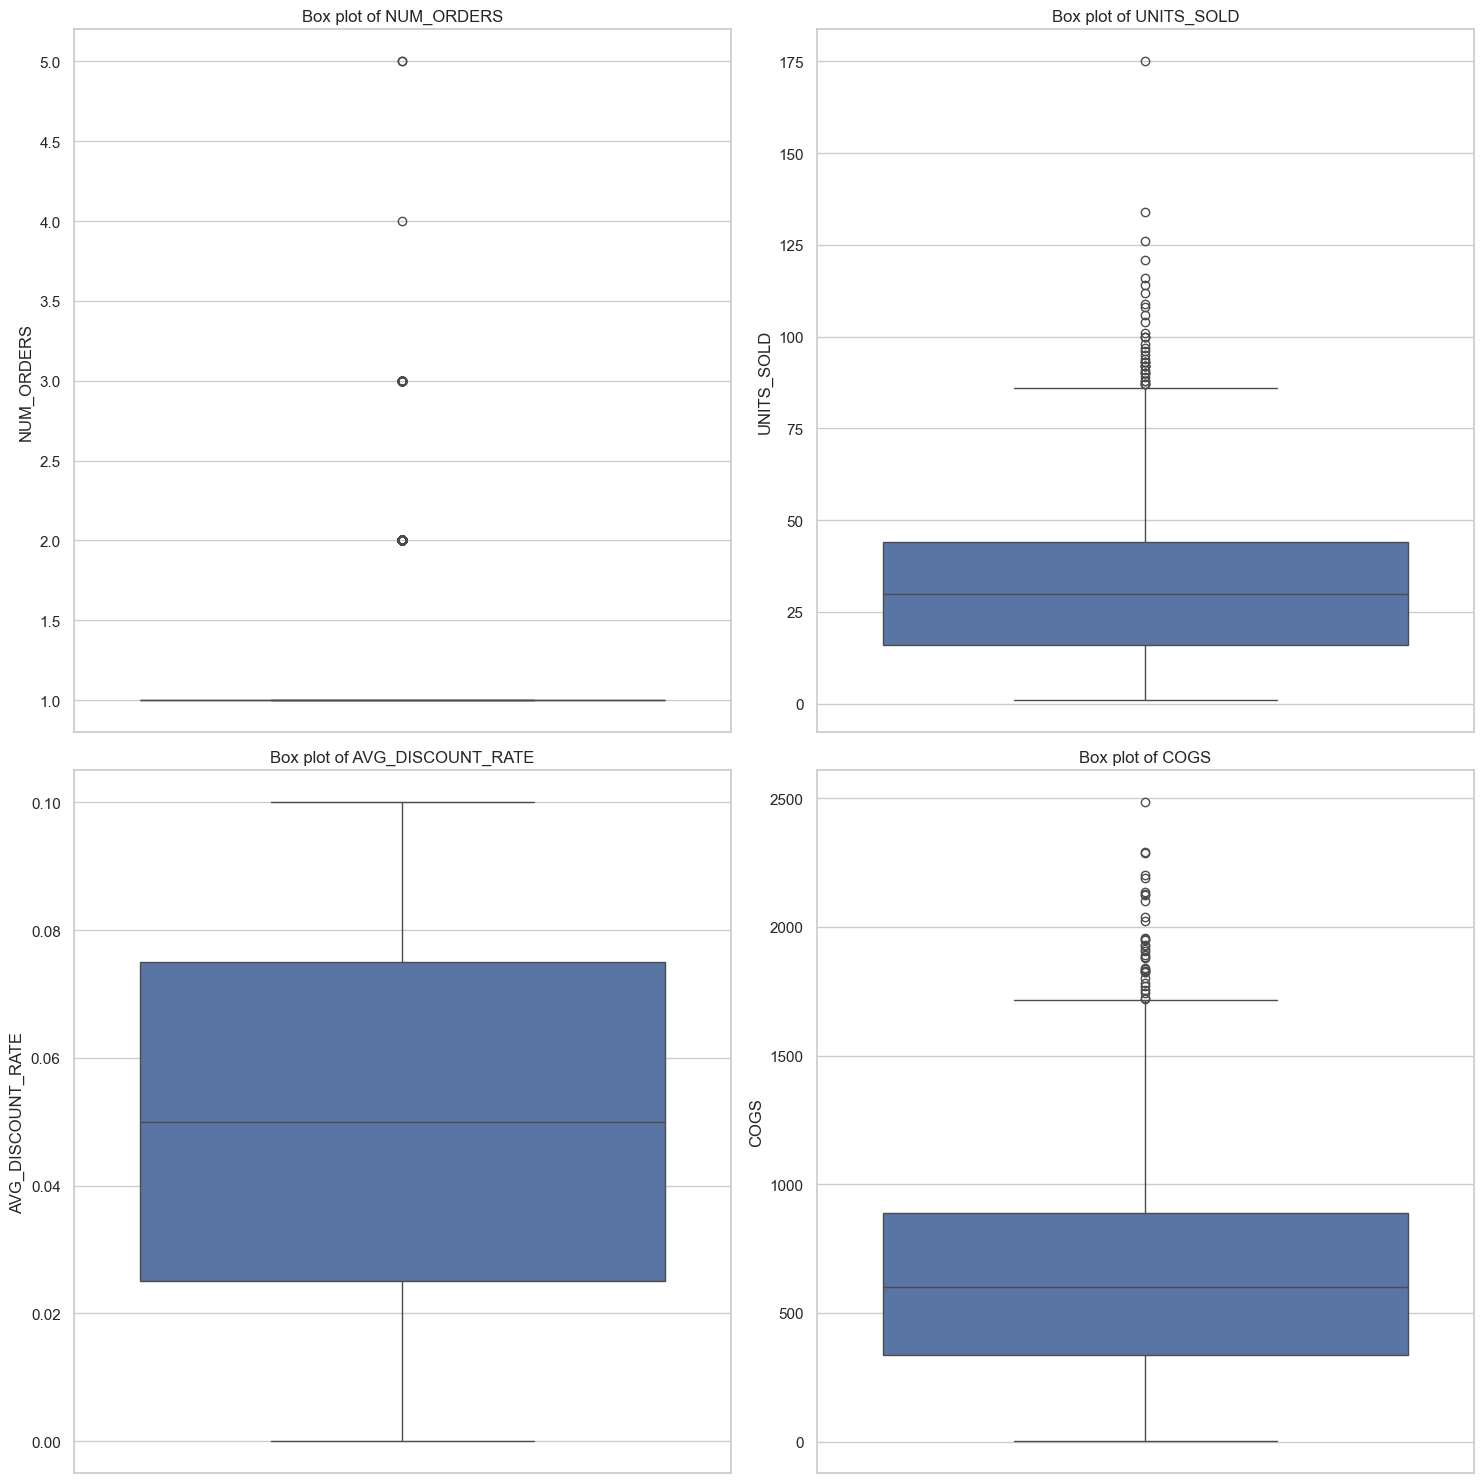

In [41]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set the style of the visualization
sns.set_theme(style="whitegrid")

# Create a figure and axis
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

# List of numerical columns to plot
numerical_columns = ['NUM_ORDERS', 'UNITS_SOLD', 'AVG_DISCOUNT_RATE', 'COGS']

# Plot each numerical column
for ax, column in zip(axes.flatten(), numerical_columns):
    sns.boxplot(y=df_raw_data[column], ax=ax)
    ax.set_title(f'Box plot of {column}')

# Adjust layout
plt.tight_layout()
plt.show()

In [42]:
# Calculate the percentage of outliers for each numerical column
outlier_percentages = {}

for column in numerical_columns:
    Q1 = df_raw_data[column].quantile(0.25)
    Q3 = df_raw_data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_raw_data[(df_raw_data[column] < lower_bound) | (df_raw_data[column] > upper_bound)]
    outlier_percentage = (len(outliers) / len(df_raw_data)) * 100
    outlier_percentages[column] = outlier_percentage


print("Percentage of outliers in each numerical column")
for column, percentage in outlier_percentages.items():
    print(f"{column}: {percentage:.2f}%")

Percentage of outliers in each numerical column
NUM_ORDERS: 20.18%
UNITS_SOLD: 1.92%
AVG_DISCOUNT_RATE: 0.00%
COGS: 1.76%


In [43]:
def treat_outliers(df, column, outlier_percentages):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # if any of the numerical columns have outliers that under 5%, we can keep them, otherwise we treat theme with mean imputation
    if outlier_percentages[column] > 5:
        # print('condition meet')
        print(lower_bound, upper_bound)
        df[column] = np.where(df[column] < lower_bound, df[column].mean(), df[column])
        df[column] = np.where(df[column] > upper_bound, df[column].mean(), df[column])
    return df

In [44]:
# df_raw_data = treat_outliers(df_raw_data, 'NUM_ORDERS', outlier_percentages)
# df_raw_data = treat_outliers(df_raw_data, 'UNITS_SOLD', outlier_percentages)
df_raw_data = treat_outliers(df_raw_data, 'AVG_DISCOUNT_RATE', outlier_percentages)
df_raw_data = treat_outliers(df_raw_data, 'COGS', outlier_percentages)

In [45]:
# Calculate the percentage of outliers for each numerical column
outlier_percentages_after_treat = {}

for column in numerical_columns:
    Q1 = df_raw_data[column].quantile(0.25)
    Q3 = df_raw_data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_raw_data[(df_raw_data[column] < lower_bound) | (df_raw_data[column] > upper_bound)]
    outlier_percentage = (len(outliers) / len(df_raw_data)) * 100
    outlier_percentages_after_treat[column] = outlier_percentage


print("Percentage of outliers in each numerical column")
for column, percentage in outlier_percentages_after_treat.items():
    print(f"{column}: {percentage:.2f}%")

Percentage of outliers in each numerical column
NUM_ORDERS: 20.18%
UNITS_SOLD: 1.92%
AVG_DISCOUNT_RATE: 0.00%
COGS: 1.76%


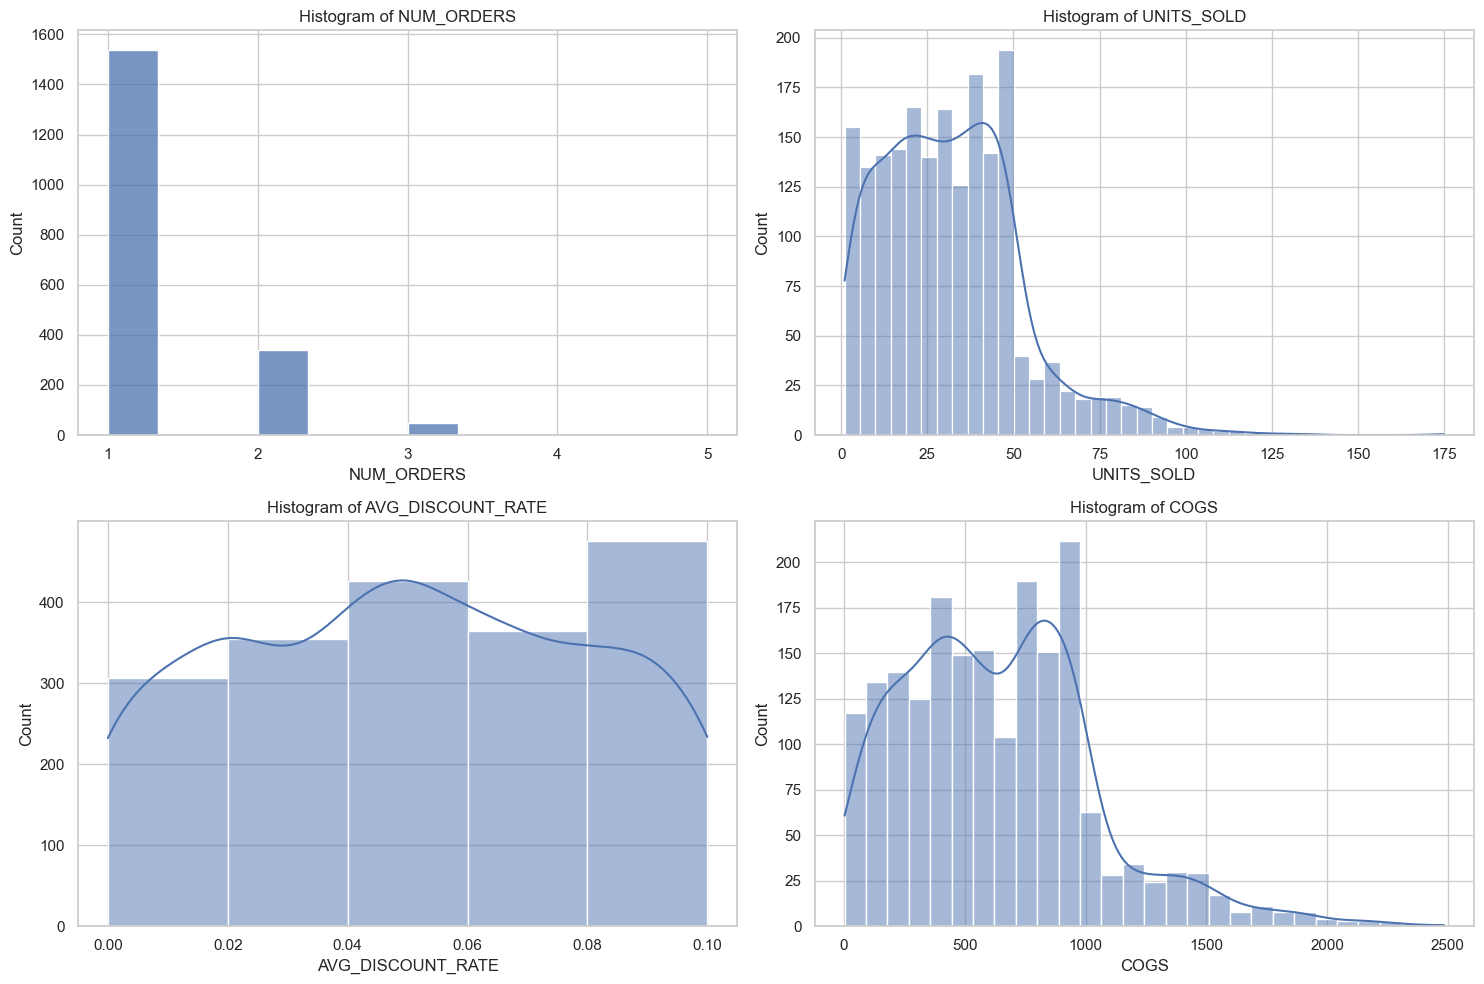

In [46]:
# Plot histograms for numeric features to understand their distribution
from matplotlib.ticker import MaxNLocator
columns_for_hist = ['NUM_ORDERS','UNITS_SOLD', 'AVG_DISCOUNT_RATE', 'COGS']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Plot each numerical column
for ax, column in zip(axes.flatten(), columns_for_hist):
    if column == 'AVG_DISCOUNT_RATE':
        sns.histplot(df_raw_data[column], kde=True, bins=5, ax=ax)  # 4 or 5 bins
    elif column == 'NUM_ORDERS':
        sns.histplot(df_raw_data[column], ax=ax)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    else:
        sns.histplot(df_raw_data[column], kde=True, ax=ax)
    ax.set_title(f'Histogram of {column}')

# Adjust layout
plt.tight_layout()
plt.show()

In [47]:
# Calculate skewness and kurtosis for each numerical column
skewness = df_raw_data[numerical_columns].skew()
kurtosis = df_raw_data[numerical_columns].kurt()

print("Skewness:\n", skewness)
print("\nKurtosis:\n", kurtosis)

Skewness:
 NUM_ORDERS           2.294063
UNITS_SOLD           1.030791
AVG_DISCOUNT_RATE   -0.008297
COGS                 0.830835
dtype: float64

Kurtosis:
 NUM_ORDERS           6.298460
UNITS_SOLD           2.249859
AVG_DISCOUNT_RATE   -1.098614
COGS                 1.025406
dtype: float64


Frequency Distribution of CUSTOMER_SEGMENT:
 CUSTOMER_SEGMENT
4    388
7    327
6    326
9    271
3    257
1    213
5     70
8     51
2     25
Name: count, dtype: int64


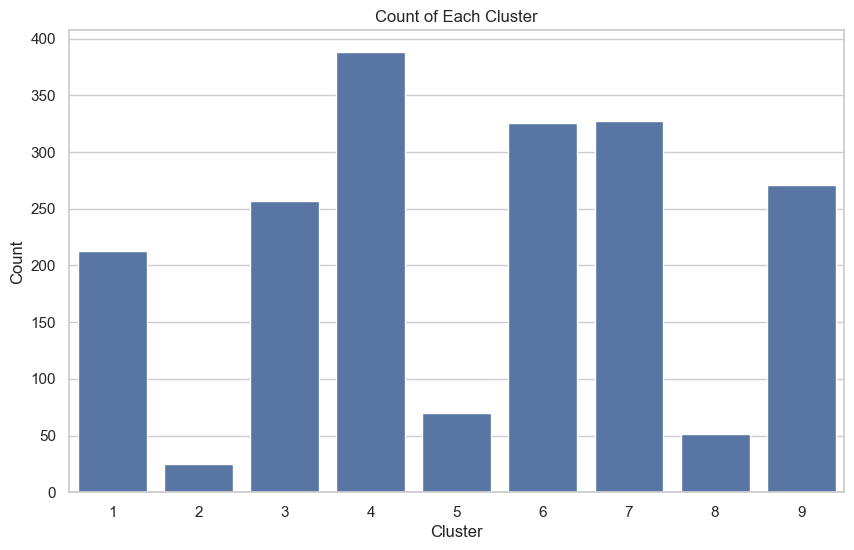

Cross-tabulation between CLUSTER and NUM_ORDERS:
 NUM_ORDERS          1   2   3  4  5
CUSTOMER_SEGMENT                   
1                 184  28   1  0  0
2                  24   1   0  0  0
3                 218  35   4  0  0
4                 275  94  19  0  0
5                  64   6   0  0  0
6                 256  61   8  1  0
7                 252  60  13  0  2
8                  44   7   0  0  0
9                 222  46   3  0  0


In [48]:
# Frequency Distribution
cluster_counts = df_raw_data['CUSTOMER_SEGMENT'].value_counts()
print("Frequency Distribution of CUSTOMER_SEGMENT:\n", cluster_counts)

# Bar Plots
plt.figure(figsize=(10, 6))
sns.countplot(x='CUSTOMER_SEGMENT', data=df_raw_data)
plt.title('Count of Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

# Cross-tabulation
cross_tab = pd.crosstab(df_raw_data['CUSTOMER_SEGMENT'], df_raw_data['NUM_ORDERS'])
print("Cross-tabulation between CLUSTER and NUM_ORDERS:\n", cross_tab)

In [49]:
# Convert DATE column to datetime
df_raw_data['DATE'] = pd.to_datetime(df_raw_data['DATE'])

df_raw_data['DATE_ORDINAL'] = df_raw_data['DATE'].apply(lambda x: x.toordinal())

df_raw_data.head()

,DATE,RETAIL_RPICE,CUSTOMER_SEGMENT,NUM_ORDERS,UNITS_SOLD,AVG_DISCOUNT_RATE,COGS,DATE_ORDINAL
0,2021-01-01,1497.736864,6,1,46,0.100000,502.97,737791
1,2021-01-01,1497.736864,5,2,45,0.015000,1456.62,737791
2,2021-01-01,1497.736864,4,3,59,0.036667,2099.15,737791
3,2021-01-01,1497.736864,2,1,30,0.080000,917.30,737791
4,2021-01-02,1497.736864,9,1,31,0.050000,340.01,737792


In [50]:
retail_price = df_raw_data['RETAIL_RPICE'][0]

In [51]:
# Select all columns except 'RETAIL_RPICE'
df_selected = df_raw_data.drop(columns=['RETAIL_RPICE', 'DATE'])

# Display the first few rows to verify the changes
df_selected.head()

,CUSTOMER_SEGMENT,NUM_ORDERS,UNITS_SOLD,AVG_DISCOUNT_RATE,COGS,DATE_ORDINAL
0,6,1,46,0.100000,502.97,737791
1,5,2,45,0.015000,1456.62,737791
2,4,3,59,0.036667,2099.15,737791
3,2,1,30,0.080000,917.30,737791
4,9,1,31,0.050000,340.01,737792


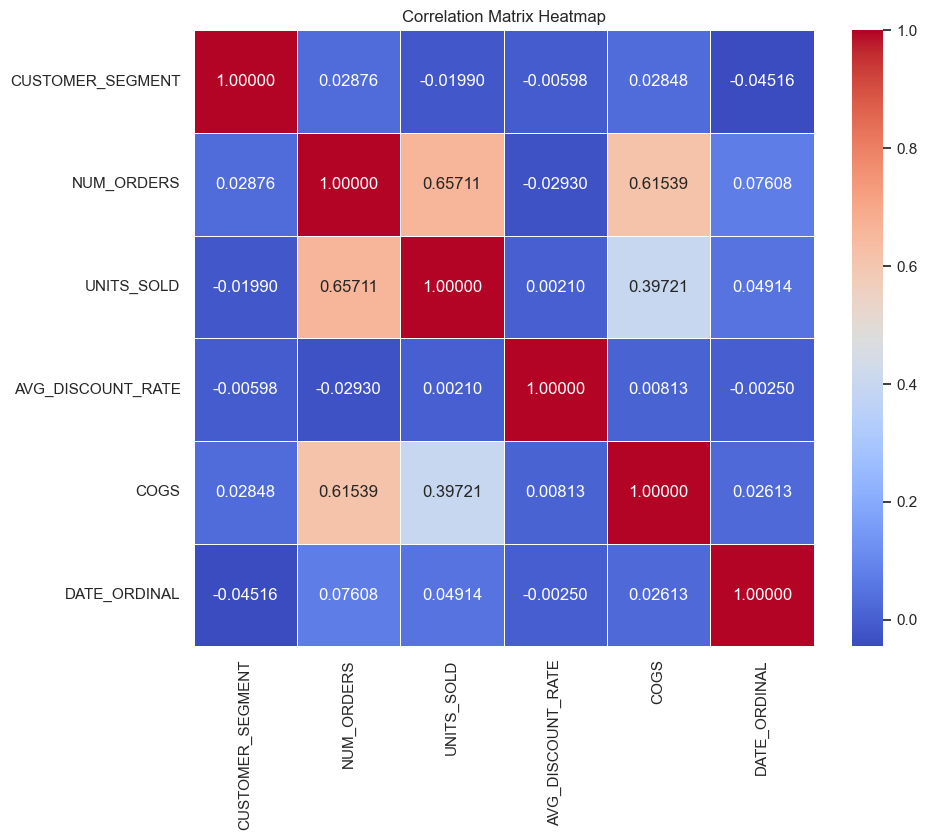

In [52]:
# Calculate the correlation matrix
corr_matrix = df_selected.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.5f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

**Feature Selection**

In [53]:
# Select the required columns for independent variables and target variable
df_model = df_raw_data[['DATE_ORDINAL', 'UNITS_SOLD', 'CUSTOMER_SEGMENT', 'AVG_DISCOUNT_RATE']].copy()

# Display the first few rows to verify the changes
df_model.head()

,DATE_ORDINAL,UNITS_SOLD,CUSTOMER_SEGMENT,AVG_DISCOUNT_RATE
0,737791,46,6,0.100000
1,737791,45,5,0.015000
2,737791,59,4,0.036667
3,737791,30,2,0.080000
4,737792,31,9,0.050000


In [54]:
df_model['CUSTOMER_SEGMENT'] = df_model['CUSTOMER_SEGMENT'].astype('int')

In [55]:
df_model['PRODUCT_SKU'] = product_sku

In [56]:
df_model

,DATE_ORDINAL,UNITS_SOLD,CUSTOMER_SEGMENT,AVG_DISCOUNT_RATE,PRODUCT_SKU
0,737791,46,6,0.100000,B33_S3
1,737791,45,5,0.015000,B33_S3
2,737791,59,4,0.036667,B33_S3
3,737791,30,2,0.080000,B33_S3
4,737792,31,9,0.050000,B33_S3
...,...,...,...,...,...
1923,738733,69,4,0.050000,B33_S3
1924,738733,57,7,0.040000,B33_S3
1925,738734,32,1,0.070000,B33_S3
1926,738734,3,4,0.050000,B33_S3


Insert Cleaned Data to snowflake ```FACT_DYNAMIC_PRICING_CLEANED```

In [57]:
# Function to create the table if it doesn't exist
def create_table_if_not_exists(table_name):
    create_table_query = f"""
    CREATE TABLE IF NOT EXISTS {table_name} (
        DATE_ORDINAL INT,
        UNITS_SOLD INT,
        CUSTOMER_SEGMENT INT,
        AVG_DISCOUNT_RATE FLOAT,
        PRODUCT_SKU STRING
    );
    """
    session.sql(create_table_query).collect()  # Execute the query

In [58]:
# Function to insert the pandas dataframe into Snowflake table using Snowpark
def insert_pandas_dataframe_to_snowflake(session, pandas_df, table_name, schema):
    # Convert pandas DataFrame to Snowpark DataFrame
    snowpark_df = session.create_dataframe(pandas_df, schema=schema)
    product_sku = pandas_df['PRODUCT_SKU'][0]
    # Write the Snowpark DataFrame into Snowflake table
    session.sql(f"DELETE FROM {table_name} WHERE PRODUCT_SKU = '{product_sku}'").collect()
    snowpark_df.write.mode("append").save_as_table(f"{table_name}")
    return snowpark_df

In [59]:
from snowflake.snowpark.types import StructType, StructField, IntegerType, FloatType, StringType 

training_table = "FACT_DYNAMIC_PRICING_CLEANED"
# schema structure for pandas DataFrame convert to Snowpark DataFrame
schema = StructType([
        StructField("DATE_ORDINAL", IntegerType()),
        StructField("UNITS_SOLD", IntegerType()),
        StructField("CUSTOMER_SEGMENT", IntegerType()),
        StructField("AVG_DISCOUNT_RATE", FloatType()),
        StructField("PRODUCT_SKU", StringType())
    ])

create_table_if_not_exists(training_table)
snowpark_df = insert_pandas_dataframe_to_snowflake(session, df_model, training_table, schema)
# Convert pandas DataFrame to Snowpark DataFrame

In [60]:
snowpark_df.show()

--------------------------------------------------------------------------------------------
|"DATE_ORDINAL"  |"UNITS_SOLD"  |"CUSTOMER_SEGMENT"  |"AVG_DISCOUNT_RATE"  |"PRODUCT_SKU"  |
--------------------------------------------------------------------------------------------
|737791          |46            |6                   |0.1                  |B33_S3         |
|737791          |45            |5                   |0.015                |B33_S3         |
|737791          |59            |4                   |0.03666667           |B33_S3         |
|737791          |30            |2                   |0.08                 |B33_S3         |
|737792          |31            |9                   |0.05                 |B33_S3         |
|737792          |33            |8                   |0.06                 |B33_S3         |
|737792          |41            |7                   |0.04                 |B33_S3         |
|737792          |35            |4                   |0.01            

**Model Training and Evaluation**

Create ```Stage``` as Internal Storage inside snowflake

In [61]:
# Create a Stage
stage_name = "DYNAMIC_PRICING_MODEL_STAGE"
session.sql(f"CREATE STAGE IF NOT EXISTS {stage_name}").collect()

[Row(status='DYNAMIC_PRICING_MODEL_STAGE already exists, statement succeeded.')]

Define Training function for ```XGboost Model```

In [62]:
def train_xgboost_model(
    session: Session,
    training_table: str,
    feature_cols: list,
    target_col: str,
    model_name: str,
    stage_name: str,
    param_grid: dict,
    test_size: float = 0.2
) ->T.Variant:
    # Import the package
    import json
    from sklearn.model_selection import GridSearchCV
    from xgboost import XGBRegressor
    from joblib import dump
    from sklearn.model_selection import train_test_split


    # Get training data 
    df_cleaned = session.table(training_table).to_pandas()

    train_set, test_set = train_test_split(df_cleaned, test_size=test_size, random_state=42)
    
    X_train = train_set[feature_cols]
    y_train = train_set[target_col]
    X_test = test_set[feature_cols]
    y_test = test_set[target_col]

    # Initialize the XGBRegressor
    xgb = XGBRegressor()
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_xgb = XGBRegressor(**best_params)
    best_xgb.fit(X_train, y_train)
    y_pred = best_xgb.predict(X_test)

    mse_test_set = np.mean((y_pred - y_test) ** 2)
    mse_train_set = np.mean((best_xgb.predict(X_train) - y_train) ** 2)
    r_squared = best_xgb.score(X_test, y_test)

    # print("Mean Squared Error: ", mse)
    # Save model
    dump(best_xgb, "/tmp/"+ model_name)
    session.file.put(
        "/tmp/"+ model_name,
        f"@{stage_name}/",
        auto_compress=False,
        overwrite=True
    )
    
    # combine mse and best_params into a dictionary
    result = {
        "mse_test_set": mse_test_set,
        "mse_train_set": mse_train_set,
        "best_params": best_params,
        "r_squared": r_squared
        # "X_train": X_train,
        # "y_train": y_train,
        # "X_test": X_test,
        # "y_test": y_test
    }
    return result
    

Register ```XGBoost``` model to Snowflake as ```Stored Procedure```

In [63]:
# train_xgb_snowflake become a stored procedure in Snowflake that can be called
train_xgboost_snowflake = session.sproc.register(
    func=train_xgboost_model,
    name="sproc_train_xgb_model_v2", #spoc = stored procedure or function in snowflake
    is_permanent=True,
    replace=True,
    stage_location=stage_name,
    packages=["snowflake-snowpark-python", "scikit-learn", "xgboost", "joblib"],
)

The version of package 'scikit-learn' in the local environment is 1.5.2, which does not fit the criteria for the requirement 'scikit-learn'. Your UDF might not work when the package version is different between the server and your local environment.


Train the ```XGBoost``` model by calling Store Precedure that we just register

In [64]:
stage_avg_discount_prediction_model_dir =  f"{stage_name}/avg_discount_rate_prediction_models"
training_table = "FACT_DYNAMIC_PRICING_CLEANED"
model_file_name = "B33_S3_xgb_model.sav"
feature_cols = [
    'DATE_ORDINAL',
    'UNITS_SOLD',
    'CUSTOMER_SEGMENT'
]
target_col = 'AVG_DISCOUNT_RATE'
# can only put 2 hyperparameters for each, since snowflake COMPUTE_WH is limited
params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Call the training store procedure by feeding the required parameters
result = train_xgboost_snowflake(
    session,
    training_table,
    feature_cols, 
    target_col, 
    model_file_name,
    stage_avg_discount_prediction_model_dir, # where model file will be stored,
    params
)

In [65]:
result_xgboost_model = json.loads(result)
result_xgboost_model

{'best_params': {'colsample_bytree': 0.8,
  'learning_rate': 0.01,
  'max_depth': 5,
  'n_estimators': 100,
  'subsample': 0.8},
 'mse_test_set': 0.0008209354829206305,
 'mse_train_set': 0.0008133040538323756,
 'r_squared': 0.0003548460558187028}

Insert the Training Result of ```XGboost``` model back to snowflake in table ```LU_PRD_PRODUCT_TRAINED```

In [66]:
# Evaluation Metrics
evaluation_metrics = {
    "mse_test_set": result_xgboost_model['mse_test_set'],
    "mse_train_set": result_xgboost_model['mse_train_set'],
    "r_squared": result_xgboost_model['r_squared']
}

hyperparameters = {
    "best_params": result_xgboost_model['best_params']
}

In [67]:
#stage_avg_discount_prediction_model_dir =  f"{stage_name}/avg_discount_rate_prediction_models"
# model_file_name = "B33_S3_xgb_model.sav"
model_path = f"{stage_avg_discount_prediction_model_dir}/{model_file_name}"

product_trained = session.sql(f"""
    SELECT * FROM LU_PRD_PRODUCT_TRAINED WHERE PRODUCT_SKU = '{product_sku}' AND MODEL_NAME = 'xgboost'
""").collect()

if len(product_trained) > 0:
    print("Product trained, now updated")
    session.sql(f"""
        UPDATE LU_PRD_PRODUCT_TRAINED 
        SET 
            PRODUCT_SKU = '{product_sku}',
            MIN_VOLUMN_SOLD = {df_model['UNITS_SOLD'].min()},
            MAX_VOLUMN_SOLD = {df_model['UNITS_SOLD'].max()},
            DATE_MODIFIED = CURRENT_TIMESTAMP(),
            MODEL_PATH = '{model_path}',
            MODEL_NAME = 'xgboost',
            EVALUATION = PARSE_JSON('{json.dumps(evaluation_metrics)}'),
            HYPER_PARAMS = PARSE_JSON('{json.dumps(hyperparameters)}')
        WHERE PRODUCT_SKU = '{product_sku}' AND MODEL_NAME = 'xgboost'
    """).collect()

else:
    print("Product not trained")
    session.sql(f"""
        INSERT INTO LU_PRD_PRODUCT_TRAINED (PRODUCT_SKU, MIN_VOLUMN_SOLD, MAX_VOLUMN_SOLD, DATE_CREATED, DATE_MODIFIED, MODEL_PATH, MODEL_NAME, EVALUATION, HYPER_PARAMS)
        SELECT 
            '{product_sku}',
            {df_model['UNITS_SOLD'].min()},
            {df_model['UNITS_SOLD'].max()}, 
            CURRENT_TIMESTAMP(), 
            CURRENT_TIMESTAMP(), 
            '{model_path}',
            'xgboost', 
            PARSE_JSON('{json.dumps(evaluation_metrics)}'),
            PARSE_JSON('{json.dumps(hyperparameters)}')
    """).collect()

Product trained, now updated


```XGBoost``` Model Deployment by define it from ```UDFs```

In [68]:
# %pip install cachetools

In [69]:
import cachetools
@cachetools.cached(cache={})
def load_model(filename):

    # Import packages
    import sys
    import os
    import joblib

    # Get the import directory where the model file is stored
    import_dir = sys._xoptions.get("snowflake_import_directory")

    # Get the import directory where the model file is stored
    if import_dir:
        with open(os.path.join(import_dir, filename), "rb") as f:
            model = joblib.load(f)
            return model

In [70]:
# Function to predict the average discount rate
def avg_discount_rate_prediction(date_ordinal: int, units_sold: int, customer_segment: int, model_name: str) -> float:
    import pandas as pd
    # Create a DataFrame from the input values (this assumes feature_cols)
    feature_cols = ['DATE_ORDINAL', 'UNITS_SOLD', 'CUSTOMER_SEGMENT']
    X = pd.DataFrame([[date_ordinal, units_sold, customer_segment]], columns=feature_cols)

    # Load the model using the model name
    model = load_model(model_name)

    # Get predictions
    predictions = model.predict(X)

    # Return the predicted value (assuming a regression model returning a single value)
    return predictions[0]


In [71]:
# Get only files in the stage under the directory dynamic_pricing_model_stage and contain .sav in the file name
files = session.sql(f"LIST @{stage_name}").collect()
model_xgboost_files = [file['name'] for file in files if file['name'].endswith('.sav')]

#insert file name without prefix dynamic_pricing_model_stage/
model_xgboost_files = [file.replace(f"{stage_name.lower()}/", "") for file in model_xgboost_files]
model_xgboost_files


['B12_S10_xgb_model.sav',
 'B13_S1_xgb_model.sav',
 'B15_S1_xgb_model.sav',
 'B15_S47_xgb_model.sav',
 'B22_S10_xgb_model.sav',
 'B31_S32_xgb_model.sav',
 'B33_S3_segment_1.sav',
 'B44_S4_xgb_model.sav',
 'avg_discount_rate_prediction_models/B33_S3_dt_model.sav',
 'avg_discount_rate_prediction_models/B33_S3_xgb_model.sav',
 'demand_forecast_models/B33_S3/B33_S3_segment_7.sav']

In [72]:
# feature_cols = [
#     'DATE_ORDINAL',
#     'UNITS_SOLD',
#     'CUSTOMER_SEGMENT'
# ]
# model_files = ['B33_S3_xgb_model.sav', 'another_model.sav', 'some_other_model.sav']
session.udf.register(
    func=avg_discount_rate_prediction,
    name="udf_avg_discount_rate_prediction_v2",
    stage_location=stage_name,
    input_type=[T.IntegerType(), T.IntegerType(), T.IntegerType(), T.StringType()],  # Three integers and one string
    return_type=T.FloatType(),  # The return type is a float
    replace=True,
    is_permanent=True,
    # imports=[f"@{stage_name}/{model_file_name}"],  # Model file is imported,
    imports=[f"@{stage_name}/{model}" for model in model_xgboost_files], # multiple model files are imported, 
    packages=["joblib", "cachetools", "xgboost","pandas"],  # Required packages for the UDF
)

Got error object of type 'NoneType' has no len() when trying to read default values from function: <function avg_discount_rate_prediction at 0x00000296BB4914E0>. Proceeding without creating optional arguments
The version of package 'cachetools' in the local environment is 5.5.0, which does not fit the criteria for the requirement 'cachetools'. Your UDF might not work when the package version is different between the server and your local environment.
The version of package 'pandas' in the local environment is 2.2.3, which does not fit the criteria for the requirement 'pandas'. Your UDF might not work when the package version is different between the server and your local environment.


Call the UDF to predict the average discount rate for a given date_ordinal, units_sold, and customer_segment

In [73]:
import snowflake.snowpark.functions as F
from datetime import datetime

In [74]:
# Get the last date of sales data
last_date = session.sql(f"""
SELECT MAX(DATE_ORDINAL) AS LAST_DATE FROM {training_table} WHERE PRODUCT_SKU = '{product_sku}'
""").collect()[0]['LAST_DATE']
last_date
regular_date = datetime.fromordinal(last_date)
print(f"last_date: {last_date}")
print(f"regular_date: {regular_date}")

last_date: 738734
regular_date: 2023-08-02 00:00:00


In [75]:
sample_data = {
    'UNITS_SOLD': [80, 90, 100, 500, 70, 60],
    'DATE_ORDINAL': [738734, 738735, 738736, 738737, 738738, 738739],
    'CUSTOMER_SEGMENT': [1,1,1,1,1,1]
}
snowpark_df_sample = session.create_dataframe(pd.DataFrame(sample_data))
snowpark_df_sample.show()

------------------------------------------------------
|"UNITS_SOLD"  |"DATE_ORDINAL"  |"CUSTOMER_SEGMENT"  |
------------------------------------------------------
|80            |738734          |1                   |
|90            |738735          |1                   |
|100           |738736          |1                   |
|500           |738737          |1                   |
|70            |738738          |1                   |
|60            |738739          |1                   |
------------------------------------------------------



In [76]:
result_test = snowpark_df_sample.select(
    "UNITS_SOLD",
    "DATE_ORDINAL",
    "CUSTOMER_SEGMENT",
    F.call_udf("udf_avg_discount_rate_prediction_v2", 
            snowpark_df_sample['DATE_ORDINAL'],
            snowpark_df_sample['UNITS_SOLD'], 
            snowpark_df_sample['CUSTOMER_SEGMENT'], 
            "B33_S3_xgb_model.sav").alias('PREDICTED_AVG_DISCOUNT_RATE')
)
results = result_test.collect()

# Print the results
for i, row in enumerate(results):
    print(f"Prediction for row {i}: {row['PREDICTED_AVG_DISCOUNT_RATE']}")

Prediction for row 0: 0.04995391145348549
Prediction for row 1: 0.05108420178294182
Prediction for row 2: 0.049859706312417984
Prediction for row 3: 0.049447979778051376
Prediction for row 4: 0.049522824585437775
Prediction for row 5: 0.04926842823624611


Define function for training ```DecisionTree``` Model

In [77]:
def train_decision_tree_model(
    session: Session,
    training_table: str,
    feature_cols: list,
    target_col: str,
    model_name: str,
    stage_name: str,
    param_grid: dict,
    test_size: float = 0.2
) ->T.Variant:
    # Import the package
    from sklearn.model_selection import GridSearchCV
    from joblib import dump
    from sklearn.model_selection import train_test_split
    from sklearn.tree import DecisionTreeRegressor


    # Get training data 
    df_cleaned = session.table(training_table).to_pandas()

    X = df_cleaned[feature_cols]
    y = df_cleaned[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)


    # Initialize the DecisionTreeRegressor
    decision_tree_reg = DecisionTreeRegressor(random_state=42)
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=decision_tree_reg, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_decision_tree_reg = grid_search.best_estimator_
    best_decision_tree_reg.fit(X_train, y_train)
    y_pred = best_decision_tree_reg.predict(X_test)

    mse_test_set = np.mean((y_pred - y_test) ** 2)
    mse_train_set = np.mean((best_decision_tree_reg.predict(X_train) - y_train) ** 2)
    r_squared = best_decision_tree_reg.score(X_test, y_test)

    # print("Mean Squared Error: ", mse)
    # Save model
    dump(best_decision_tree_reg, "/tmp/"+ model_name)
    session.file.put(
        "/tmp/"+ model_name,
        f"@{stage_name}/",
        auto_compress=False,
        overwrite=True
    )
    
    # combine mse and best_params into a dictionary
    result = {
        "mse_test_set": mse_test_set,
        "mse_train_set": mse_train_set,
        "best_params": best_params,
        "r_squared": r_squared
    }
    return result
    

register function for training ```DecisionTree``` model as ```Stored Procedure``` to snowflake

In [78]:
# train_xgb_snowflake become a stored procedure in Snowflake that can be called
train_decision_tree_snowflake = session.sproc.register(
    func=train_decision_tree_model,
    name="sproc_train_decision_tree_model_v1", #spoc = stored procedure or function in snowflake
    is_permanent=True,
    replace=True,
    stage_location=stage_name,
    packages=["snowflake-snowpark-python", "scikit-learn", "xgboost", "joblib"],
)

The version of package 'scikit-learn' in the local environment is 1.5.2, which does not fit the criteria for the requirement 'scikit-learn'. Your UDF might not work when the package version is different between the server and your local environment.


Train the ```DecisionTree``` model by calling Store Precedure that we just registerd

In [79]:
model_dt_file_name = "B33_S3_dt_model.sav"
# can only put 2 hyperparameters for each, since snowflake COMPUTE_WH is limited
param_grid_dt_model = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Call the training store procedure by feeding the required parameters
result_dt_train = train_decision_tree_snowflake(
    session,
    training_table,
    feature_cols, 
    target_col, 
    model_dt_file_name,
    stage_avg_discount_prediction_model_dir, # where model file will be stored,
    param_grid_dt_model
)

In [80]:
result_dt_model = json.loads(result_dt_train)
result_dt_model

{'best_params': {'criterion': 'absolute_error',
  'max_depth': 10,
  'min_samples_leaf': 5,
  'min_samples_split': 20},
 'mse_test_set': 0.0008461826376338912,
 'mse_train_set': 0.0008138473374549096,
 'r_squared': -0.03038836870961026}

Insert the Training Result of ```DecisionTree``` model back to snowflake in table ```LU_PRD_PRODUCT_TRAINED```

In [81]:
# Evaluation Metrics
dt_evaluation_metrics = {
    "mse_test_set": result_dt_model['mse_test_set'],
    "mse_train_set": result_dt_model['mse_train_set'],
    "r_squared": result_dt_model['r_squared']
}

dt_hyperparameters = {
    "best_params": result_dt_model['best_params']
}

In [82]:
#stage_avg_discount_prediction_model_dir =  f"{stage_name}/avg_discount_rate_prediction_models"
# model_file_name = "B33_S3_xgb_model.sav"
model_dt_path = f"{stage_avg_discount_prediction_model_dir}/{model_dt_file_name}"

product_trained = session.sql(f"""
    SELECT * FROM LU_PRD_PRODUCT_TRAINED WHERE PRODUCT_SKU = '{product_sku}' AND MODEL_NAME = 'decision_tree'
""").collect()

if len(product_trained) > 0:
    print("Product trained, now updated")
    session.sql(f"""
        UPDATE LU_PRD_PRODUCT_TRAINED 
        SET 
            PRODUCT_SKU = '{product_sku}',
            MIN_VOLUMN_SOLD = {df_model['UNITS_SOLD'].min()},
            MAX_VOLUMN_SOLD = {df_model['UNITS_SOLD'].max()},
            DATE_MODIFIED = CURRENT_TIMESTAMP(),
            MODEL_PATH = '{model_dt_path}',
            MODEL_NAME = 'decision_tree',
            EVALUATION = PARSE_JSON('{json.dumps(dt_evaluation_metrics)}'),
            HYPER_PARAMS = PARSE_JSON('{json.dumps(dt_hyperparameters)}')
        WHERE PRODUCT_SKU = '{product_sku}' AND MODEL_NAME = 'decision_tree'
    """).collect()

else:
    print("Product not trained")
    session.sql(f"""
        INSERT INTO LU_PRD_PRODUCT_TRAINED (PRODUCT_SKU, MIN_VOLUMN_SOLD, MAX_VOLUMN_SOLD, DATE_CREATED, DATE_MODIFIED, MODEL_PATH, MODEL_NAME, EVALUATION, HYPER_PARAMS)
        SELECT 
            '{product_sku}',
            {df_model['UNITS_SOLD'].min()},
            {df_model['UNITS_SOLD'].max()}, 
            CURRENT_TIMESTAMP(), 
            CURRENT_TIMESTAMP(), 
            '{model_dt_path}',
            'decision_tree', 
            PARSE_JSON('{json.dumps(dt_evaluation_metrics)}'),
            PARSE_JSON('{json.dumps(dt_hyperparameters)}')
    """).collect()

Product trained, now updated


```DecisionTree``` Model Deployment by define it from ```UDFs```

In [83]:
# Get only files in the stage under the directory dynamic_pricing_model_stage and contain .sav in the file name
files = session.sql(f"LIST @{stage_name}").collect()
model_xgboost_files = [file['name'] for file in files if file['name'].endswith('.sav')]

#insert file name without prefix dynamic_pricing_model_stage/
model_xgboost_files = [file.replace(f"{stage_name.lower()}/", "") for file in model_xgboost_files]
model_xgboost_files


['B12_S10_xgb_model.sav',
 'B13_S1_xgb_model.sav',
 'B15_S1_xgb_model.sav',
 'B15_S47_xgb_model.sav',
 'B22_S10_xgb_model.sav',
 'B31_S32_xgb_model.sav',
 'B33_S3_segment_1.sav',
 'B44_S4_xgb_model.sav',
 'avg_discount_rate_prediction_models/B33_S3_dt_model.sav',
 'avg_discount_rate_prediction_models/B33_S3_xgb_model.sav',
 'demand_forecast_models/B33_S3/B33_S3_segment_7.sav']

In [84]:
# feature_cols = [
#     'DATE_ORDINAL',
#     'UNITS_SOLD',
#     'CUSTOMER_SEGMENT'
# ]
# model_files = ['B33_S3_xgb_model.sav', 'another_model.sav', 'some_other_model.sav']
session.udf.register(
    func=avg_discount_rate_prediction,
    name="udf_avg_discount_rate_prediction_v2",
    stage_location=stage_name,
    input_type=[T.IntegerType(), T.IntegerType(), T.IntegerType(), T.StringType()],  # Three integers and one string
    return_type=T.FloatType(),  # The return type is a float
    replace=True,
    is_permanent=True,
    # imports=[f"@{stage_name}/{model_file_name}"],  # Model file is imported,
    imports=[f"@{stage_name}/{model}" for model in model_xgboost_files], # multiple model files are imported, 
    packages=["joblib", "cachetools", "xgboost","pandas", "scikit-learn"],  # Required packages for the UDF
)

Got error object of type 'NoneType' has no len() when trying to read default values from function: <function avg_discount_rate_prediction at 0x00000296BB4914E0>. Proceeding without creating optional arguments
The version of package 'cachetools' in the local environment is 5.5.0, which does not fit the criteria for the requirement 'cachetools'. Your UDF might not work when the package version is different between the server and your local environment.
The version of package 'pandas' in the local environment is 2.2.3, which does not fit the criteria for the requirement 'pandas'. Your UDF might not work when the package version is different between the server and your local environment.
The version of package 'scikit-learn' in the local environment is 1.5.2, which does not fit the criteria for the requirement 'scikit-learn'. Your UDF might not work when the package version is different between the server and your local environment.


In [85]:
snowpark_df_sample.show()

------------------------------------------------------
|"UNITS_SOLD"  |"DATE_ORDINAL"  |"CUSTOMER_SEGMENT"  |
------------------------------------------------------
|80            |738734          |1                   |
|90            |738735          |1                   |
|100           |738736          |1                   |
|500           |738737          |1                   |
|70            |738738          |1                   |
|60            |738739          |1                   |
------------------------------------------------------



In [86]:
result_dt_test_pred = snowpark_df_sample.select(
    "UNITS_SOLD",
    "DATE_ORDINAL",
    "CUSTOMER_SEGMENT",
    F.call_udf("udf_avg_discount_rate_prediction_v2", 
            snowpark_df_sample['DATE_ORDINAL'],
            snowpark_df_sample['UNITS_SOLD'], 
            snowpark_df_sample['CUSTOMER_SEGMENT'], 
            "B33_S3_dt_model.sav").alias('PREDICTED_AVG_DISCOUNT_RATE')
)
results_dt_pred_test = result_dt_test_pred.collect()

# Print the results
for i, row in enumerate(results_dt_pred_test):
    print(f"Prediction for row {i}: {row['PREDICTED_AVG_DISCOUNT_RATE']}")

Prediction for row 0: 0.047083335000000004
Prediction for row 1: 0.048
Prediction for row 2: 0.045
Prediction for row 3: 0.045
Prediction for row 4: 0.045
Prediction for row 5: 0.034166665


Model comparison base on ```MSE```

In [87]:
# Compare the MSE of XGBoost and DecisionTree models
xgboost_mse_test = result_xgboost_model['mse_test_set']
decision_tree_mse_test = result_dt_model['mse_test_set']

print(f"XGBoost Model Test MSE: {xgboost_mse_test}")
print(f"DecisionTree Model Test MSE: {decision_tree_mse_test}")
best_model_str = ""
if xgboost_mse_test < decision_tree_mse_test:
    best_model_str = "xgboost"
    print("XGBoost model performs better based on MSE.")
else:
    best_model_str = "decision_tree"
    print("DecisionTree model performs better based on MSE.")

XGBoost Model Test MSE: 0.0008209354829206305
DecisionTree Model Test MSE: 0.0008461826376338912
XGBoost model performs better based on MSE.


Insert best model result to ```LU_PRD_PRODUCT_SKU_PREDICTED```

In [88]:
all_model_result = {
    'xgboost': {
        'evaluation_metrics': evaluation_metrics,
        'hyperparameters': hyperparameters,
    },
    'decision_tree': {
        'evaluation_metrics': dt_evaluation_metrics,
        'hyperparameters': dt_hyperparameters,
    }
}


In [89]:
all_model_result[best_model_str]['evaluation_metrics']
all_model_result[best_model_str]['hyperparameters']


{'best_params': {'colsample_bytree': 0.8,
  'learning_rate': 0.01,
  'max_depth': 5,
  'n_estimators': 100,
  'subsample': 0.8}}

In [90]:
lu_prd_product_sku_trained = 'LU_PRD_PRODUCT_SKU_PREDICTED'
product_trained = session.sql(f"""
    SELECT * FROM {lu_prd_product_sku_trained} WHERE PRODUCT_SKU = '{product_sku}' AND MODEL_NAME = '{best_model_str}'
""").collect()

if len(product_trained) > 0:
    print("Product trained, now updated")
    session.sql(f"""
        UPDATE {lu_prd_product_sku_trained} 
        SET 
            PRODUCT_SKU = '{product_sku}',
            MIN_VOLUMN_SOLD = {df_model['UNITS_SOLD'].min()},
            MAX_VOLUMN_SOLD = {df_model['UNITS_SOLD'].max()},
            DATE_MODIFIED = CURRENT_TIMESTAMP(),
            MODEL_PATH = '{model_dt_path}',
            MODEL_NAME = '{best_model_str}',
            EVALUATION = PARSE_JSON('{json.dumps(all_model_result[best_model_str]['evaluation_metrics'])}'),
            HYPER_PARAMS = PARSE_JSON('{json.dumps(all_model_result[best_model_str]['hyperparameters'])}')
        WHERE PRODUCT_SKU = '{product_sku}' AND MODEL_NAME = '{best_model_str}'
    """).collect()

else:
    print("Product not trained")
    session.sql(f"""
        INSERT INTO {lu_prd_product_sku_trained} (PRODUCT_SKU, MIN_VOLUMN_SOLD, MAX_VOLUMN_SOLD, DATE_CREATED, DATE_MODIFIED, MODEL_PATH, MODEL_NAME, EVALUATION, HYPER_PARAMS)
        SELECT 
            '{product_sku}',
            {df_model['UNITS_SOLD'].min()},
            {df_model['UNITS_SOLD'].max()}, 
            CURRENT_TIMESTAMP(), 
            CURRENT_TIMESTAMP(), 
            '{model_dt_path}',
            '{best_model_str}', 
            PARSE_JSON('{json.dumps(all_model_result[best_model_str]['evaluation_metrics'])}'),
            PARSE_JSON('{json.dumps(all_model_result[best_model_str]['hyperparameters'])}')
    """).collect()

Product trained, now updated


**Call and use the best model with demand forecasting model**

```ARIMA``` and ```XGboost```

In [111]:
model_demand_forecasting_files

['demand_forecast_models/B33_S3/B33_S3_segment_1.pkl',
 'demand_forecast_models/B33_S3/B33_S3_segment_2.pkl',
 'demand_forecast_models/B33_S3/B33_S3_segment_3.pkl',
 'demand_forecast_models/B33_S3/B33_S3_segment_4.pkl',
 'demand_forecast_models/B33_S3/B33_S3_segment_5.pkl',
 'demand_forecast_models/B33_S3/B33_S3_segment_6.pkl',
 'demand_forecast_models/B33_S3/B33_S3_segment_7.pkl',
 'demand_forecast_models/B33_S3/B33_S3_segment_8.pkl',
 'demand_forecast_models/B33_S3/B33_S3_segment_9.pkl']

In [93]:
n_periods = 7
demand_predict_result = {}
for segment, model_file in enumerate(model_demand_forecasting_files):
    file_name = os.path.basename(model_file)
    result = session.sql(f"""
        SELECT udf_demand_forecast_prediction('{file_name}', {n_periods}) as DEMAND_FORECAST
    """).collect()
    json_result = json.loads(result[0]['DEMAND_FORECAST'])
    json_result_dict = json.loads(json_result)
    demand_predict_result[segment] = json_result_dict
    print(f"Segment {segment+1} Forecast: {json_result_dict['forecast']}")

Segment 1 Forecast: [5.693855932203391, 5.693855932203391, 5.693855932203391, 5.693855932203391, 5.693855932203391, 5.693855932203391, 5.693855932203391]
Segment 2 Forecast: [0.05320691998862913, 0.05303228776154129, 0.0645656322458848, 0.0645656322458848, 0.0645656322458848, 0.0645656322458848, 0.0645656322458848]
Segment 3 Forecast: [2.62279969397043, 2.6771481178352965, 2.730715094664838, 2.783511860469699, 2.835549489703911, 2.8868388975878316, 2.9373908423976784]
Segment 4 Forecast: [18.156481998369195, 17.92979849393545, 17.71339352491949, 17.506801030543755, 17.309576082676507, 17.12129392761188, 16.941549071298667]
Segment 5 Forecast: [0.0006601595719515826, 0.0006833330848042726, 0.0006620181929276435, 0.0006816235336716407, 0.0006635906302953076, 0.0006801772129222752, 0.0006649209495519356]
Segment 6 Forecast: [4.678720774515718, 4.8527622885210775, 5.020990935638334, 5.183600861624332, 5.340779727901141, 5.492708928128377, 5.639563797542165]
Segment 7 Forecast: [9.337916328

In [95]:
regular_date # last date of sales data

datetime.datetime(2023, 8, 2, 0, 0)

In [96]:
forecast_index = pd.date_range(start=regular_date, periods=n_periods, freq='D')
forecast_index

DatetimeIndex(['2023-08-02', '2023-08-03', '2023-08-04', '2023-08-05',
               '2023-08-06', '2023-08-07', '2023-08-08'],
              dtype='datetime64[ns]', freq='D')

In [103]:
forecast_df_for_each_segment = {}
for segment, result in demand_predict_result.items():
    # Calculate the total units sold in the forecast
    forecast_df_for_each_segment[segment] = pd.DataFrame(result['forecast'], index=forecast_index, columns=['UNITS_SOLD'])
    total_units_sold = forecast_df_for_each_segment[segment]['UNITS_SOLD'].sum()
    forecast_df_for_each_segment[segment]['WEIGHT_PERCENTAGE'] = (forecast_df_for_each_segment[segment]['UNITS_SOLD'] / total_units_sold) * 100

In [127]:
forecast_df_for_each_segment[1]

,UNITS_SOLD,WEIGHT_PERCENTAGE
2023-08-02,0.053207,12.400598
2023-08-03,0.053032,12.359898
2023-08-04,0.064566,15.047901
2023-08-05,0.064566,15.047901
2023-08-06,0.064566,15.047901
2023-08-07,0.064566,15.047901
2023-08-08,0.064566,15.047901


In [137]:
expected_units_sold = 700
i=1
volume_sold_by_date = (forecast_df_for_each_segment[i-1]['WEIGHT_PERCENTAGE'] / 100) * expected_units_sold
sample_data = {
    'UNITS_SOLD': volume_sold_by_date.to_list(),
    'DATE_ORDINAL': [738734, 738735, 738736, 738737, 738738, 738739, 738740],
    'CUSTOMER_SEGMENT': [i, i, i, i, i, i, i],
}
snowpark_predict_sample = session.create_dataframe(pd.DataFrame(sample_data))
snowpark_predict_result = snowpark_predict_sample.select(
    "UNITS_SOLD",
    "DATE_ORDINAL",
    "CUSTOMER_SEGMENT",
    F.call_udf("udf_avg_discount_rate_prediction_v2", 
            snowpark_predict_sample['DATE_ORDINAL'],
            snowpark_predict_sample['UNITS_SOLD'], 
            snowpark_predict_sample['CUSTOMER_SEGMENT'], 
            "B33_S3_xgb_model.sav").alias('PREDICTED_AVG_DISCOUNT_RATE')
).collect()
snowpark_predict_result

[Row(UNITS_SOLD=100.0, DATE_ORDINAL=738740, CUSTOMER_SEGMENT=1, PREDICTED_AVG_DISCOUNT_RATE=0.04995391145348549),
 Row(UNITS_SOLD=100.0, DATE_ORDINAL=738734, CUSTOMER_SEGMENT=1, PREDICTED_AVG_DISCOUNT_RATE=0.04995391145348549),
 Row(UNITS_SOLD=100.0, DATE_ORDINAL=738735, CUSTOMER_SEGMENT=1, PREDICTED_AVG_DISCOUNT_RATE=0.04995391145348549),
 Row(UNITS_SOLD=100.0, DATE_ORDINAL=738736, CUSTOMER_SEGMENT=1, PREDICTED_AVG_DISCOUNT_RATE=0.04995391145348549),
 Row(UNITS_SOLD=100.0, DATE_ORDINAL=738737, CUSTOMER_SEGMENT=1, PREDICTED_AVG_DISCOUNT_RATE=0.04995391145348549),
 Row(UNITS_SOLD=100.0, DATE_ORDINAL=738738, CUSTOMER_SEGMENT=1, PREDICTED_AVG_DISCOUNT_RATE=0.04995391145348549),
 Row(UNITS_SOLD=100.0, DATE_ORDINAL=738739, CUSTOMER_SEGMENT=1, PREDICTED_AVG_DISCOUNT_RATE=0.04995391145348549)]

In [114]:
model_file_name

'B33_S3_xgb_model.sav'

In [140]:
expected_units_sold = 700
each_cluster_average_discount_rate = []
# i=1
for i in customer_segement:
    volume_sold_by_date = (forecast_df_for_each_segment[i-1]['WEIGHT_PERCENTAGE'] / 100) * expected_units_sold
    sample_data = {
        'UNITS_SOLD': volume_sold_by_date.to_list(),
        'DATE_ORDINAL': [738734, 738735, 738736, 738737, 738738, 738739, 738740],
        'CUSTOMER_SEGMENT': [i, i, i, i, i, i, i],
    }
    snowpark_predict_sample = session.create_dataframe(pd.DataFrame(sample_data))
    snowpark_predict_result = snowpark_predict_sample.select(
        "UNITS_SOLD",
        "DATE_ORDINAL",
        "CUSTOMER_SEGMENT",
        F.call_udf("udf_avg_discount_rate_prediction_v2", 
                snowpark_predict_sample['DATE_ORDINAL'],
                snowpark_predict_sample['UNITS_SOLD'], 
                snowpark_predict_sample['CUSTOMER_SEGMENT'], 
                "B33_S3_xgb_model.sav").alias('PREDICTED_AVG_DISCOUNT_RATE')
    )
    min_discount_rate = snowpark_predict_result.select(F.min(snowpark_predict_result['PREDICTED_AVG_DISCOUNT_RATE'])).collect()[0][0]
    max_discount_rate = snowpark_predict_result.select(F.max(snowpark_predict_result['PREDICTED_AVG_DISCOUNT_RATE'])).collect()[0][0]

    each_cluster_average_discount_rate.append({
            'min_discount_rate': min_discount_rate,
            'max_discount_rate': max_discount_rate
        })
    print(f"Customer Segment {i}: Min Discount Rate: {min_discount_rate}, Max Discount Rate: {max_discount_rate}")


Customer Segment 1: Min Discount Rate: 0.04995391145348549, Max Discount Rate: 0.04995391145348549
Customer Segment 2: Min Discount Rate: 0.05071604996919632, Max Discount Rate: 0.05087490752339363
Customer Segment 3: Min Discount Rate: 0.049906156957149506, Max Discount Rate: 0.050631627440452576
Customer Segment 4: Min Discount Rate: 0.049906156957149506, Max Discount Rate: 0.050631627440452576
Customer Segment 5: Min Discount Rate: 0.0500580333173275, Max Discount Rate: 0.0500580333173275
Customer Segment 6: Min Discount Rate: 0.04937724769115448, Max Discount Rate: 0.050147198140621185
Customer Segment 7: Min Discount Rate: 0.04985162243247032, Max Discount Rate: 0.04985162243247032
Customer Segment 8: Min Discount Rate: 0.05032219737768173, Max Discount Rate: 0.05032219737768173
Customer Segment 9: Min Discount Rate: 0.048509303480386734, Max Discount Rate: 0.04892849922180176


In [141]:
each_cluster_average_discount_rate

[{'min_discount_rate': 0.04995391145348549,
  'max_discount_rate': 0.04995391145348549},
 {'min_discount_rate': 0.05071604996919632,
  'max_discount_rate': 0.05087490752339363},
 {'min_discount_rate': 0.049906156957149506,
  'max_discount_rate': 0.050631627440452576},
 {'min_discount_rate': 0.049906156957149506,
  'max_discount_rate': 0.050631627440452576},
 {'min_discount_rate': 0.0500580333173275,
  'max_discount_rate': 0.0500580333173275},
 {'min_discount_rate': 0.04937724769115448,
  'max_discount_rate': 0.050147198140621185},
 {'min_discount_rate': 0.04985162243247032,
  'max_discount_rate': 0.04985162243247032},
 {'min_discount_rate': 0.05032219737768173,
  'max_discount_rate': 0.05032219737768173},
 {'min_discount_rate': 0.048509303480386734,
  'max_discount_rate': 0.04892849922180176}]

```ARIMA``` and ```DecisionTree```

In [143]:
each_cluster_average_discount_rate_using_dt = []
# i=1
for i in customer_segement:
    volume_sold_by_date = (forecast_df_for_each_segment[i-1]['WEIGHT_PERCENTAGE'] / 100) * expected_units_sold
    sample_data = {
        'UNITS_SOLD': volume_sold_by_date.to_list(),
        'DATE_ORDINAL': [738734, 738735, 738736, 738737, 738738, 738739, 738740],
        'CUSTOMER_SEGMENT': [i, i, i, i, i, i, i],
    }
    snowpark_predict_sample = session.create_dataframe(pd.DataFrame(sample_data))
    snowpark_predict_result = snowpark_predict_sample.select(
        "UNITS_SOLD",
        "DATE_ORDINAL",
        "CUSTOMER_SEGMENT",
        F.call_udf("udf_avg_discount_rate_prediction_v2", 
                snowpark_predict_sample['DATE_ORDINAL'],
                snowpark_predict_sample['UNITS_SOLD'], 
                snowpark_predict_sample['CUSTOMER_SEGMENT'], 
                "B33_S3_dt_model.sav").alias('PREDICTED_AVG_DISCOUNT_RATE')
    )
    min_discount_rate = snowpark_predict_result.select(F.min(snowpark_predict_result['PREDICTED_AVG_DISCOUNT_RATE'])).collect()[0][0]
    max_discount_rate = snowpark_predict_result.select(F.max(snowpark_predict_result['PREDICTED_AVG_DISCOUNT_RATE'])).collect()[0][0]

    each_cluster_average_discount_rate_using_dt.append({
            'min_discount_rate': min_discount_rate,
            'max_discount_rate': max_discount_rate
        })
    print(f"Customer Segment {i}: Min Discount Rate: {min_discount_rate}, Max Discount Rate: {max_discount_rate}")


Customer Segment 1: Min Discount Rate: 0.047083335000000004, Max Discount Rate: 0.047083335000000004
Customer Segment 2: Min Discount Rate: 0.034166665, Max Discount Rate: 0.035
Customer Segment 3: Min Discount Rate: 0.035, Max Discount Rate: 0.047083335000000004
Customer Segment 4: Min Discount Rate: 0.035, Max Discount Rate: 0.047083335000000004
Customer Segment 5: Min Discount Rate: 0.047083335000000004, Max Discount Rate: 0.047083335000000004
Customer Segment 6: Min Discount Rate: 0.034166665, Max Discount Rate: 0.048
Customer Segment 7: Min Discount Rate: 0.047083335000000004, Max Discount Rate: 0.047083335000000004
Customer Segment 8: Min Discount Rate: 0.047083335000000004, Max Discount Rate: 0.047083335000000004
Customer Segment 9: Min Discount Rate: 0.034166665, Max Discount Rate: 0.047083335000000004


Apply Price to the Disount

In [145]:
# Calculate new prices based on min and max discount rates for each customer segment
price_ranges = []

for segment in customer_segement:
    min_discount_rate_xgb = each_cluster_average_discount_rate[segment-1]['min_discount_rate']
    max_discount_rate_xgb = each_cluster_average_discount_rate[segment-1]['max_discount_rate']
    min_discount_rate_dt = each_cluster_average_discount_rate_using_dt[segment-1]['min_discount_rate']
    max_discount_rate_dt = each_cluster_average_discount_rate_using_dt[segment-1]['max_discount_rate']
    
    new_price_max_xgb = retail_price * (1 - min_discount_rate_xgb)
    new_price_min_xgb = retail_price * (1 - max_discount_rate_xgb)
    new_price_max_dt = retail_price * (1 - min_discount_rate_dt)
    new_price_min_dt = retail_price * (1 - max_discount_rate_dt)
    
    price_ranges.append({
        'Customer Segment': segment,
        'XGBoost Min Price': new_price_min_xgb,
        'XGBoost Max Price': new_price_max_xgb,
        'DecisionTree Min Price': new_price_min_dt,
        'DecisionTree Max Price': new_price_max_dt
    })

# Convert the price ranges to a DataFrame for better visualization
df_price_ranges = pd.DataFrame(price_ranges)
df_price_ranges

,Customer Segment,XGBoost Min Price,XGBoost Max Price,DecisionTree Min Price,DecisionTree Max Price
0,1,1422.919049,1422.919049,1427.218417,1427.218417
1,2,1421.539639,1421.777566,1445.316073,1446.564190
2,3,1421.904009,1422.990573,1427.218417,1445.316073
3,4,1421.904009,1422.990573,1427.218417,1445.316073
4,5,1422.763102,1422.763102,1427.218417,1427.218417
5,6,1422.629556,1423.782740,1425.845494,1446.564190
6,7,1423.072251,1423.072251,1427.218417,1427.218417
7,8,1422.367454,1422.367454,1427.218417,1427.218417
8,9,1424.454847,1425.082692,1427.218417,1446.564190


In [146]:
retail_price

1497.73686372